In [1]:
import os
import glob
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

print("--- Block 1: Setup and Data Ingestion (Updated) ---")

# --- 1. Define File Paths for Kaggle ---
# The data is already unzipped in the directory you provided.
JSON_DIR = '/kaggle/input/webcam-gaze-data-json-filtered/approved_files'

# NEW PATH for the single-stream classifier model
PATH_SOURCE_CLASSIFIER_SINGLE = '/kaggle/input/classifier-head-meaningfull-only/tensorflow2/default/1/dyslexia_profile_model.h5'

# --- 2. Verify Data Directory ---
if os.path.exists(JSON_DIR):
    print(f"Data directory confirmed at: {JSON_DIR}")
    
    # Quick check: Count how many files are there
    json_files = glob.glob(os.path.join(JSON_DIR, "*.json"))
    if len(json_files) > 0:
        print(f"Found {len(json_files)} JSON files ready for processing.")
    else:
        print(f"WARNING: Directory exists but no .json files found inside.")
else:
    print(f"ERROR: Directory not found at '{JSON_DIR}'.")
    print("Available files in /kaggle/input/:")
    for root, dirs, files in os.walk('/kaggle/input/'):
        for file in files:
            print(os.path.join(root, file))

# --- 3. Load the 'scaler_v2.pkl' ---
# CRITICAL FIX: The old scaler is numerically incompatible with Webcam data.
# We comment out the loading and set scaler to None for now.
# We will fit a new scaler on the TARGET data later in the pipeline.
SCALER_PATH = '/kaggle/input/gaze-encoder/tensorflow2/default/1/scaler_v2.pkl'
scaler = None

# try:
#     with open(SCALER_PATH, 'rb') as f:
#         scaler = pickle.load(f)
#     print(f"Successfully loaded 'scaler_v2.pkl'.")
# except FileNotFoundError:
#     print(f"WARNING: 'scaler_v2.pkl' not found at '{SCALER_PATH}'. We will generate a new one.")
#     scaler = None
# except Exception as e:
#     print(f"Error loading scaler: {e}. We will generate a new one.")
#     scaler = None

if scaler is None:
    print("\nScaler is intentionally set to None. We will generate or fit a new scaler on the target domain later.")

print("\nSetup complete.")

--- Block 1: Setup and Data Ingestion (Updated) ---
Data directory confirmed at: /kaggle/input/webcam-gaze-data-json-filtered/approved_files
Found 327 JSON files ready for processing.

Scaler is intentionally set to None. We will generate or fit a new scaler on the target domain later.

Setup complete.


In [2]:
import glob
import json
import os
import pandas as pd

print("--- Block 2: Environment Check & Data Selection (Streamlined) ---")

# --- 1. Define Trial Inclusion/Exclusion ---
# CRITICAL: We are filtering for 'nr' (Natural Reading) to match ETDD70 Meaningful.
# We are ignoring 'is' (Information Seeking).
INCLUDED_CONDITIONS = ['nr']
print(f"Target Condition: {INCLUDED_CONDITIONS} (Ordinary Reading)")

# --- 2. Find and Load One JSON File ---
# Use the path confirmed in Block 1
JSON_DIR = '/kaggle/input/webcam-gaze-data-json-filtered/approved_files'
json_files = glob.glob(os.path.join(JSON_DIR, '*.json'))

if not json_files:
    print(f"ERROR: No JSON files found in '{JSON_DIR}'. Check your paths.")
else:
    # Grab the first file to inspect structure
    example_file_path = json_files[0]
    print(f"Found {len(json_files)} JSON files. Inspecting: {os.path.basename(example_file_path)}")
    
    with open(example_file_path, 'r') as f:
        participant_data = json.load(f)

    # --- 3. Verify Data Integrity ---
    # Check for Raw Data (Option A)
    has_raw_gaze = 'webgazer_raw_data' in participant_data and participant_data['webgazer_raw_data']
    
    if has_raw_gaze:
        print("SUCCESS: 'webgazer_raw_data' found.")
        
        # Peek at trial names to confirm 'nr' exists
        if 'set_trials' in participant_data:
            print(f"Trials in this session: {participant_data['set_trials']}")
            
            # Quick check if this participant has the trials we want
            # Note: We can't easily check conditions from 'set_trials' list alone, 
            # we usually have to parse the raw data keys or 'trial_x_condition' fields.
            # We will do the heavy filtering in the main loop (Block 4).
    else:
        print("WARNING: 'webgazer_raw_data' NOT found in this file.")

    # --- 4. Skip Heavy Visualization ---
    print("\nSkipping detailed visualization for now.")
    print("We will normalize coordinates (0-1) and filter trials in the main processing loop.")

--- Block 2: Environment Check & Data Selection (Streamlined) ---
Target Condition: ['nr'] (Ordinary Reading)
Found 327 JSON files. Inspecting: A2YTY52FZNII62_mturk_EN_v09.json
SUCCESS: 'webgazer_raw_data' found.
Trials in this session: ['meco_para_11', 'a_Rhine_2', 'a_HarvardUniversity_0', 'a_IntergovernmentalPanelonClimateChange_2', 'a_Oxygen_1']

Skipping detailed visualization for now.
We will normalize coordinates (0-1) and filter trials in the main processing loop.


In [3]:
import numpy as np

print("--- Block 3 (Optimized): Fixation Detection (I-VT with Smoothing) ---")

def get_euclidean_distance(p1, p2):
    """Euclidean distance between two (x, y) tuples."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def smooth_points(points, alpha=0.5):
    """
    Applies Exponential Moving Average (EMA) to smooth jittery webcam data.
    alpha: Smoothing factor (0 < alpha <= 1). 
           Lower = smoother but more lag. 0.5 is a good balance for 30Hz webcams.
    """
    if not points:
        return []
    
    smoothed = []
    # Initialize with the first point
    prev_x = points[0]['x']
    prev_y = points[0]['y']
    
    smoothed.append(points[0])
    
    for i in range(1, len(points)):
        curr = points[i]
        # Apply smoothing formula: New = alpha * Current + (1-alpha) * Previous
        new_x = alpha * curr['x'] + (1 - alpha) * prev_x
        new_y = alpha * curr['y'] + (1 - alpha) * prev_y
        
        smoothed.append({'x': new_x, 'y': new_y, 't': curr['t']})
        
        prev_x = new_x
        prev_y = new_y
        
    return smoothed

def detect_fixations(gaze_points_list, velocity_threshold_px_per_sec=1000, min_duration_ms=50, do_smoothing=True):
    """Identify fixations from (x, y, t) gaze points via I-VT."""
    if len(gaze_points_list) < 2:
        return []

    # --- 1. Apply Smoothing (The "Noise Filter") ---
    if do_smoothing:
        # We use alpha=0.5 to calm down the webcam jitter before calculating velocity
        process_points = smooth_points(gaze_points_list, alpha=0.5)
    else:
        process_points = gaze_points_list

    fixations = []
    velocities = [0.0]

    # --- 2. Compute point-to-point velocities ---
    for i in range(1, len(process_points)):
        p1, p2 = process_points[i-1], process_points[i]
        
        # Integrity check
        if any(k not in p1 or k not in p2 for k in ('x','y','t')):
            velocities.append(0.0)
            continue
            
        dist_px = get_euclidean_distance((p1['x'], p1['y']), (p2['x'], p2['y']))
        time_diff_sec = (p2['t'] - p1['t']) / 1000.0
        
        # Avoid division by zero
        if time_diff_sec > 0:
            velocity = dist_px / time_diff_sec
        else:
            velocity = 0.0
            
        velocities.append(velocity)

    # --- 3. Group low-velocity points into fixations ---
    current_fixation_points = []
    
    for i, point in enumerate(process_points):
        velocity = velocities[i]
        
        # If the eye is moving slower than the threshold, it's a fixation
        if velocity < velocity_threshold_px_per_sec:
            current_fixation_points.append(point)
        else:
            # Saccade detected: close the previous fixation group
            if current_fixation_points:
                dur = current_fixation_points[-1]['t'] - current_fixation_points[0]['t']
                # Only keep if it lasts long enough (min_duration_ms)
                if dur >= min_duration_ms:
                    mean_x = np.mean([p['x'] for p in current_fixation_points])
                    mean_y = np.mean([p['y'] for p in current_fixation_points])
                    fixations.append({'duration': dur, 'x': mean_x, 'y': mean_y})
                current_fixation_points = []

    # --- 4. Close final fixation (if any) ---
    if current_fixation_points:
        dur = current_fixation_points[-1]['t'] - current_fixation_points[0]['t']
        if dur >= min_duration_ms:
            mean_x = np.mean([p['x'] for p in current_fixation_points])
            mean_y = np.mean([p['y'] for p in current_fixation_points])
            fixations.append({'duration': dur, 'x': mean_x, 'y': mean_y})

    return fixations

print("I-VT fixation detection function is ready (with Smoothing added).")

--- Block 3 (Optimized): Fixation Detection (I-VT with Smoothing) ---
I-VT fixation detection function is ready (with Smoothing added).


In [4]:
import json
import glob
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import pickle
import warnings

print("--- Block 4: Preprocessing Pipeline (Single-Stream: NR Only) ---")

# --- 1. Constants & Configuration ---
if 'detect_fixations' not in locals():
    raise RuntimeError("FATAL: detect_fixations function not found. Please run Block 3.")

# Model expects sequences of length 20
SEQUENCE_LENGTH = 20
STEP = 5

# Fixation Detection Parameters (Optimized for Webcam)
# Note: Since we normalize coordinates to 0-1, the velocity threshold must also be normalized.
# Old: 1000px/s on ~1600px screen ~= 0.6 screen_units/s
VELOCITY_THRESHOLD_NORM = 0.5  # normalized units per second
MIN_FIXATION_MS = 50
MAX_FIXATION_MS = 1500

MODEL_FEATURE_NAMES = [
    "CURRENT_FIX_DURATION",
    "CURRENT_FIX_X",
    "CURRENT_FIX_Y",
    "PREVIOUS_SAC_AMPLITUDE",
    "IS_REGRESSION"
]

# --- 2. Initialize Storage ---
# We will store processed DataFrames first, then fit a new scaler, then sequence.
raw_trial_data = [] # List of tuples: (participant_id, fix_df)

total_points_processed = 0
total_points_filtered = 0
trials_processed_count = 0

json_file_paths = glob.glob(os.path.join(JSON_DIR, "*.json"))
print(f"Found {len(json_file_paths)} JSON files to process.\n")

# --- 3. Main Processing Loop (Feature Extraction) ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    for file_path in tqdm(json_file_paths, desc="Processing Participants"):
        try:
            with open(file_path, "r") as f:
                participant_data = json.load(f)

            participant_id = participant_data.get("participant", os.path.basename(file_path))
            raw_gaze_str = participant_data.get("webgazer_raw_data", None)
            
            if not raw_gaze_str:
                continue

            # Get Screen Resolution for Normalization
            webcam_width = participant_data.get("screen_x", None)
            webcam_height = participant_data.get("screen_y", None)
            
            # Skip if resolution is missing or invalid
            if not webcam_width or not webcam_height or webcam_width <= 0 or webcam_height <= 0:
                continue

            # Map trial names to conditions (to filter for 'nr')
            trial_conditions = {}
            if 'set_trials' in participant_data:
                for i, t_name in enumerate(participant_data['set_trials']):
                    cond_key = f"trial_{i}_condition"
                    if cond_key in participant_data:
                        trial_conditions[t_name] = participant_data[cond_key]
            
            raw_gaze_dict = json.loads(raw_gaze_str)

            for trial_name, gaze_points_list in raw_gaze_dict.items():
                # 1. FILTER: Only 'nr' (Natural Reading) trials
                if trial_conditions.get(trial_name) != 'nr':
                    continue

                if not isinstance(gaze_points_list, list) or len(gaze_points_list) < 2:
                    continue

                # 2. NORMALIZE & CLEAN Raw Points
                points = []
                for p in gaze_points_list:
                    total_points_processed += 1
                    if len(p) >= 3 and p[0] is not None and p[1] is not None and p[2] is not None:
                        try:
                            px, py, pt = float(p[0]), float(p[1]), float(p[2])
                            
                            # Normalize to [0, 1] range
                            px_norm = px / webcam_width
                            py_norm = py / webcam_height
                            
                            # Spatial Filter: Reject off-screen points
                            if (px_norm < 0.0) or (px_norm > 1.0) or (py_norm < 0.0) or (py_norm > 1.0):
                                total_points_filtered += 1
                                continue 
                            
                            points.append({'x': px_norm, 'y': py_norm, 't': pt})
                        except (ValueError, TypeError):
                            total_points_filtered += 1
                            continue
                
                if len(points) < 2:
                    continue

                # 3. DETECT FIXATIONS (I-VT with Smoothing)
                fixations = detect_fixations(points, 
                                             velocity_threshold_px_per_sec=VELOCITY_THRESHOLD_NORM, 
                                             min_duration_ms=MIN_FIXATION_MS,
                                             do_smoothing=True) # Enable our new smoothing
                
                if not fixations:
                    continue
                
                # Filter huge outliers in duration
                fixations = [f for f in fixations if f["duration"] <= MAX_FIXATION_MS]
                
                if len(fixations) < SEQUENCE_LENGTH:
                    continue

                # 4. FEATURE ENGINEERING (Unscaled)
                fix_df = pd.DataFrame(fixations)
                
                # Rename columns to match model expectations
                fix_df["CURRENT_FIX_X"] = fix_df["x"] # Already normalized 0-1
                fix_df["CURRENT_FIX_Y"] = fix_df["y"] # Already normalized 0-1
                fix_df["CURRENT_FIX_DURATION"] = fix_df["duration"]
                
                # Calculate Saccades
                fix_df["PREV_X"] = fix_df["CURRENT_FIX_X"].shift(1)
                fix_df["PREV_Y"] = fix_df["CURRENT_FIX_Y"].shift(1)
                fix_df.fillna(0, inplace=True) # First fixation has no previous
                
                dx = fix_df["CURRENT_FIX_X"] - fix_df["PREV_X"]
                dy = fix_df["CURRENT_FIX_Y"] - fix_df["PREV_Y"]
                fix_df["PREVIOUS_SAC_AMPLITUDE"] = np.sqrt(dx**2 + dy**2)
                
                # Regression flag
                fix_df["IS_REGRESSION"] = np.where(
                    fix_df["CURRENT_FIX_X"] < fix_df["PREV_X"], 1, 0
                )
                
                # Store for scaling phase
                raw_trial_data.append((participant_id, fix_df[MODEL_FEATURE_NAMES]))
                trials_processed_count += 1

        except Exception as e:
            # print(f"Error processing file {file_path}: {e}")
            continue

print(f"\nStep 1 Complete. Extracted features from {trials_processed_count} trials.")
filter_percent = (total_points_filtered / total_points_processed * 100) if total_points_processed > 0 else 0
print(f"Raw Data Filter Stats: {total_points_filtered}/{total_points_processed} points removed ({filter_percent:.2f}%)")

# --- 4. FIT NEW SCALER ---
if not raw_trial_data:
    print("❌ No valid data found. Check filtering logic.")
else:
    print("\n--- Fitting New Scaler on Target Data ---")
    # Concatenate all data to fit the scaler
    all_features_df = pd.concat([df for _, df in raw_trial_data], ignore_index=True)
    
    # Initialize and fit NEW scaler
    target_scaler = StandardScaler()
    target_scaler.fit(all_features_df)
    
    print("New Scaler Fitted.")
    print(f"Mean: {target_scaler.mean_}")
    print(f"Scale: {target_scaler.scale_}")
    
    # Save this scaler for future inference!
    with open('target_domain_scaler.pkl', 'wb') as f:
        pickle.dump(target_scaler, f)
    print("Saved 'target_domain_scaler.pkl'")

    # --- 5. GENERATE SEQUENCES ---
    print("\n--- Generating Sequences ---")
    all_sequences_list = []
    participant_map_list = []
    
    for participant_id, df in raw_trial_data:
        # Transform features using the new scaler
        scaled_features = target_scaler.transform(df)
        
        # Sliding window sequence generation
        for i in range(0, len(scaled_features) - SEQUENCE_LENGTH + 1, STEP):
            seq = scaled_features[i : i + SEQUENCE_LENGTH]
            all_sequences_list.append(seq)
            participant_map_list.append(participant_id)

    # --- 6. SAVE FINAL DATASET ---
    if all_sequences_list:
        # Make X_target globally available
        globals()['X_target'] = np.array(all_sequences_list, dtype=np.float32)
        
        OUTPUT_FILE = 'X_target.npy'
        np.save(OUTPUT_FILE, X_target)
        
        # Save participant map
        with open('participant_map_target.pkl', 'wb') as f:
            pickle.dump(participant_map_list, f)
            
        print(f"\n✅ Successfully created CLEAN sequence dataset.")
        print(f"   New Shape: {X_target.shape}  (N, {SEQUENCE_LENGTH}, 5)")
        print(f"   Participants represented: {len(set(participant_map_list))}")
        print(f"   File saved to {OUTPUT_FILE}")
    else:
        print("❌ Error: No sequences generated after scaling.")

--- Block 4: Preprocessing Pipeline (Single-Stream: NR Only) ---
Found 327 JSON files to process.



Processing Participants:   0%|          | 0/327 [00:00<?, ?it/s]


Step 1 Complete. Extracted features from 1018 trials.
Raw Data Filter Stats: 105756/1515440 points removed (6.98%)

--- Fitting New Scaler on Target Data ---
New Scaler Fitted.
Mean: [185.64710312   0.48163164   0.50137552   0.19934804   0.37173941]
Scale: [1.83737343e+02 1.93854151e-01 1.98296823e-01 1.78585772e-01
 4.83269305e-01]
Saved 'target_domain_scaler.pkl'

--- Generating Sequences ---

✅ Successfully created CLEAN sequence dataset.
   New Shape: (9025, 20, 5)  (N, 20, 5)
   Participants represented: 269
   File saved to X_target.npy


--- Block 5 (Corrected): Final Analysis and Sanity Check ---

Descriptive statistics for *scaled* target data:
       CURRENT_FIX_DURATION  CURRENT_FIX_X  CURRENT_FIX_Y  \
count           180500.0000    180500.0000    180500.0000   
mean                 0.0150         0.0162         0.0002   
std                  1.0036         1.0006         0.9723   
min                 -0.7383        -2.4517        -2.4880   
25%                 -0.6076        -0.7305        -0.6917   
50%                 -0.3083         0.0260        -0.0071   
75%                  0.1598         0.7783         0.6800   
max                  7.1425         2.6294         2.4801   

       PREVIOUS_SAC_AMPLITUDE  IS_REGRESSION  
count             180500.0000    180500.0000  
mean                  -0.0593        -0.0126  
std                    0.9596         0.9969  
min                   -1.1143        -0.7692  
25%                   -0.7383        -0.7692  
50%                   -0.4161        -0.7692  
75%       

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

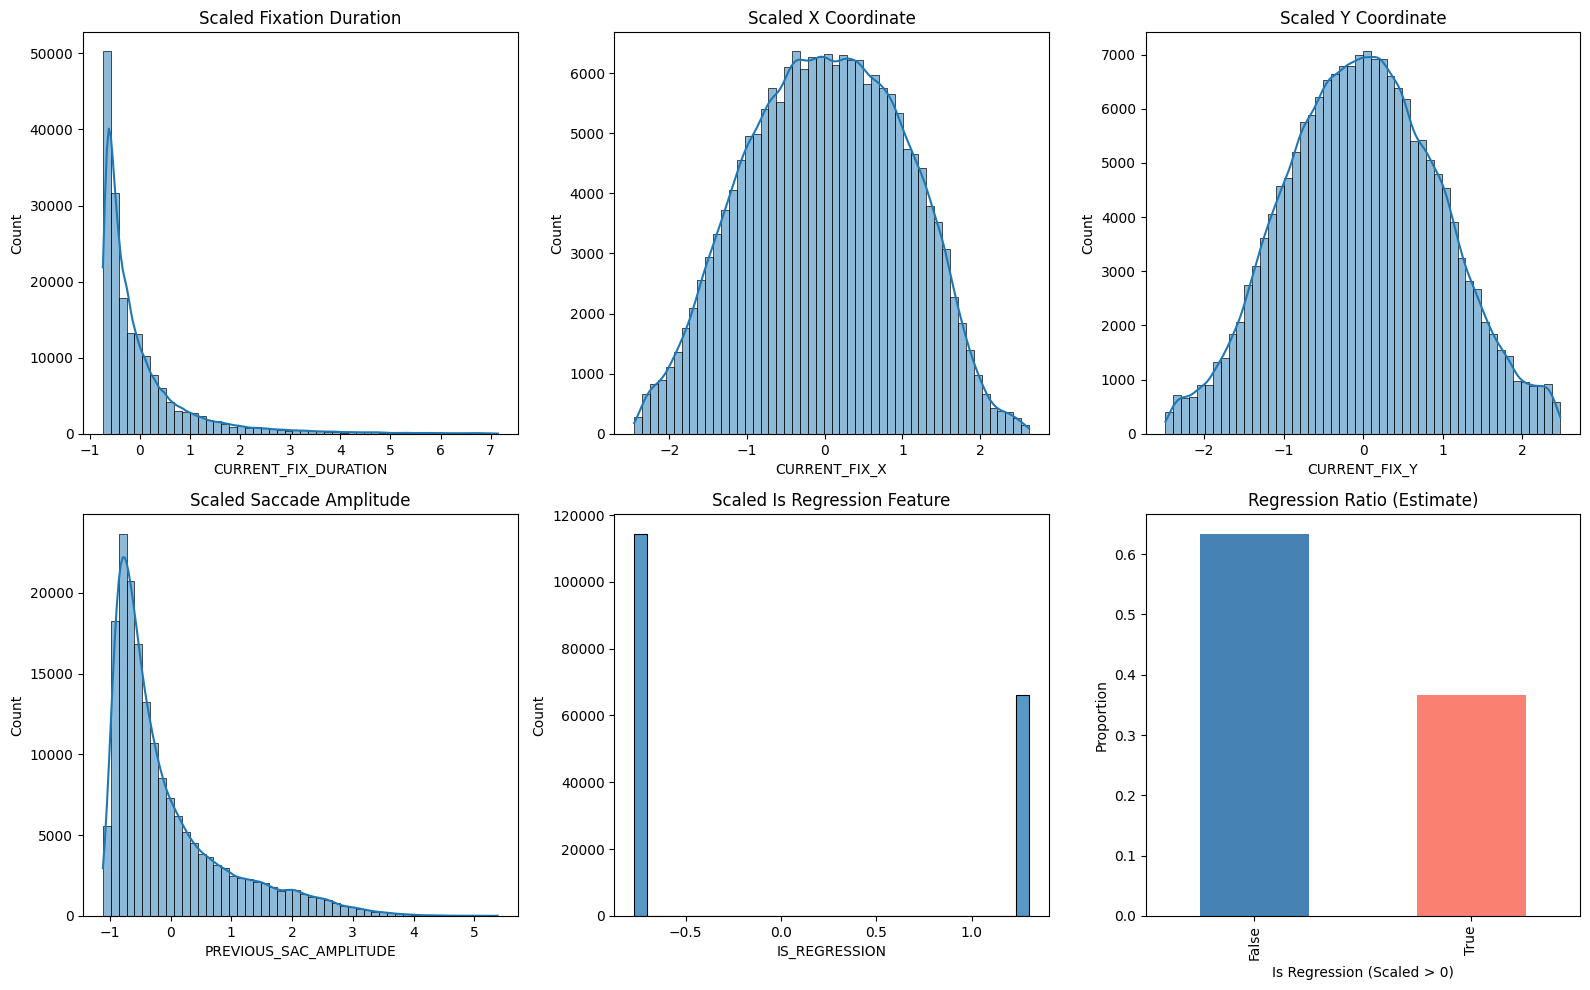


--- Sanity Check ---
• Scaled features should have mean ≈ 0 and std ≈ 1.
                         mean    std
CURRENT_FIX_DURATION    0.015  1.004
CURRENT_FIX_X           0.016  1.001
CURRENT_FIX_Y           0.000  0.972
PREVIOUS_SAC_AMPLITUDE -0.059  0.960
IS_REGRESSION          -0.013  0.997

✅ Mean/STD values look perfect (Mean ~0, Std ~1).

✅ Scaling verification complete. Data is ready for downstream inference or UDA training.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("--- Block 5 (Corrected): Final Analysis and Sanity Check ---")

if 'X_target' in locals():
    # --- 1. Flatten and Prepare Data ---
    # Use the feature names variable defined in Block 4
    if 'MODEL_FEATURE_NAMES' not in locals():
        # Define it just in case this block is run separately
        MODEL_FEATURE_NAMES = [
            "CURRENT_FIX_DURATION",
            "CURRENT_FIX_X",
            "CURRENT_FIX_Y",
            "PREVIOUS_SAC_AMPLITUDE",
            "IS_REGRESSION"
        ]
        print("Warning: MODEL_FEATURE_NAMES not in scope, using default.")
        
    X_target_reshaped = X_target.reshape(-1, X_target.shape[-1])
    analysis_df = pd.DataFrame(X_target_reshaped, columns=MODEL_FEATURE_NAMES)
    
    print("\nDescriptive statistics for *scaled* target data:")
    print(analysis_df.describe().round(4))
    
    # --- 2. Visualize Distributions ---
    print("\nPlotting scaled feature distributions...")
    plt.figure(figsize=(16, 10))
    
    # Plot 1: Fixation Duration (Scaled)
    plt.subplot(2, 3, 1)
    sns.histplot(analysis_df['CURRENT_FIX_DURATION'], kde=True, bins=50)
    plt.title('Scaled Fixation Duration')
    
    # Plot 2: X Coordinate (Scaled)
    plt.subplot(2, 3, 2)
    sns.histplot(analysis_df['CURRENT_FIX_X'], kde=True, bins=50)
    plt.title('Scaled X Coordinate')

    # Plot 3: Y Coordinate (Scaled)
    plt.subplot(2, 3, 3)
    sns.histplot(analysis_df['CURRENT_FIX_Y'], kde=True, bins=50)
    plt.title('Scaled Y Coordinate')

    # Plot 4: Saccade Amplitude (Scaled)
    plt.subplot(2, 3, 4)
    sns.histplot(analysis_df['PREVIOUS_SAC_AMPLITUDE'], kde=True, bins=50)
    plt.title('Scaled Saccade Amplitude')
    
    # Plot 5: Is Regression (Scaled)
    plt.subplot(2, 3, 5)
    # Use histplot for consistency, 'bins=3' is good for a 0/1 (or scaled 0/1) feature
    sns.histplot(analysis_df['IS_REGRESSION'], bins=30) 
    plt.title('Scaled Is Regression Feature')
    
    # Plot 6: Regression Ratio (Entire Dataset)
    plt.subplot(2, 3, 6)
    # We check if the scaled value is > 0 (since mean is 0, >0 likely means '1' or regression)
    # OR better yet, just look at the distribution
    reg_ratio = (analysis_df['IS_REGRESSION'] > 0).value_counts(normalize=True)
    reg_ratio.plot(kind='bar', color=['steelblue', 'salmon'], title='Regression Ratio (Estimate)')
    plt.xlabel('Is Regression (Scaled > 0)')
    plt.ylabel('Proportion')

    plt.tight_layout()
    plt.show()
    
    # --- 3. Sanity Check ---
    print("\n--- Sanity Check ---")
    print("• Scaled features should have mean ≈ 0 and std ≈ 1.")
    means = analysis_df.mean().round(3)
    stds = analysis_df.std().round(3)
    
    sanity_check_df = pd.DataFrame({'mean': means, 'std': stds})
    print(sanity_check_df)
    
    # Check if any means/stds are wildly off (e.g., the old bug)
    if (sanity_check_df['mean'].abs() > 0.1).any() or (abs(sanity_check_df['std'] - 1.0) > 0.1).any():
        print("\n⚠️ WARNING: Some feature means or STDs are slightly off.")
        print("Since we fitted a NEW scaler on THIS data, they should be exactly 0 and 1.")
        print("If they are not, check if X_target contains data not included in the scaler fit.")
    else:
        print("\n✅ Mean/STD values look perfect (Mean ~0, Std ~1).")

    print("\n✅ Scaling verification complete. "
          "Data is ready for downstream inference or UDA training.")

else:
    print("❌ ERROR: 'X_target' array not found. Please run Block 4 first.")

In [6]:
import numpy as np
import pickle
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Model

print("--- Block 6: Save Final Artifacts to Drive ---")

#!! IMPORTANT: Define your output paths in Google Drive!!
OUTPUT_NPY_PATH = '/kaggle/working/X_target.npy'
OUTPUT_PKL_PATH = '/kaggle/working/participant_map_target.pkl'

if 'X_target' in locals():
    # --- 1. Save X_target.npy ---
    try:
        print(f"Saving 'X_target.npy' to {OUTPUT_NPY_PATH}...")
        np.save(OUTPUT_NPY_PATH, X_target)
        print("Save complete.")
    except Exception as e:
        print(f"Error saving X_target.npy: {e}")

    # --- 2. Save participant_map_target.pkl ---
    try:
        print(f"Saving 'participant_map_target.pkl' to {OUTPUT_PKL_PATH}...")
        with open(OUTPUT_PKL_PATH, 'wb') as f:
            pickle.dump(participant_map_list, f)
        print("Save complete.")
    except Exception as e:
        print(f"Error saving participant_map_target.pkl: {e}")
        
    print("\nAll target domain artifacts are saved.")

else:
    print("ERROR: 'X_target' array not found. Cannot save.")

2025-11-19 18:37:27.579333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763577447.818444      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763577447.880140      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- Block 6: Save Final Artifacts to Drive ---
Saving 'X_target.npy' to /kaggle/working/X_target.npy...
Save complete.
Saving 'participant_map_target.pkl' to /kaggle/working/participant_map_target.pkl...
Save complete.

All target domain artifacts are saved.


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import os

print("--- Block 7: Load Assets & Prepare Single-Stream Data ---")

# --- 1. Define Paths ---
# Target Data (Generated in Block 4/6)
PATH_X_TARGET = '/kaggle/working/X_target.npy'

# Source Data (ETDD70 - Kaggle Input)
PATH_X_TRAIN_SOURCE = '/kaggle/input/etdd70-data/tensorflow2/default/1/X_train_source.npy'

# Source Model (The NEW Single-Stream Classifier)
# Use the path you confirmed earlier
PATH_SOURCE_CLASSIFIER_SINGLE = '/kaggle/input/classifier-head-meaningfull-only/tensorflow2/default/1/dyslexia_profile_model.h5'

# --- 2. Load Target Data (Webcam) ---
try:
    X_target = np.load(PATH_X_TARGET)
    print(f"✅ Loaded X_target.npy. Shape: {X_target.shape}")
except Exception as e:
    raise RuntimeError(f"FATAL: Could not load X_target.npy. Did Block 4 finish? {e}")

# --- 3. Load & Process Source Data (ETDD70 - MEANINGFUL ONLY) ---
try:
    # Load the dictionary
    source_data_dict = np.load(PATH_X_TRAIN_SOURCE, allow_pickle=True).item()
    
    # EXTRACT ONLY MEANINGFUL READING
    # Original shape: (Subjects, Sequences_per_subject, 20, 5)
    X_source_raw = source_data_dict['input_meaningful']
    print(f"Loaded Source (Meaningful) Raw Shape: {X_source_raw.shape}")
    
    # Flatten subjects and sequences into one dimension
    # (N * S, 20, 5)
    X_source_flat = X_source_raw.reshape(-1, 20, 5)
    
    # CRITICAL: REMOVE PADDING
    # ETDD70 has zero-padding. Webcam data does not. 
    # The Discriminator will cheat if we don't remove zeros from Source.
    # We calculate the sum of absolute values for each sequence. If 0, it's padding.
    sums = np.sum(np.abs(X_source_flat), axis=(1, 2))
    non_zero_indices = np.where(sums > 0)[0]
    
    X_source_clean = X_source_flat[non_zero_indices]
    
    print(f"Source Data Cleaning:")
    print(f"  - Original Flattened: {X_source_flat.shape[0]}")
    print(f"  - Zero-Padding Removed: {X_source_flat.shape[0] - X_source_clean.shape[0]}")
    print(f"✅ Final Source Shape: {X_source_clean.shape}")

except Exception as e:
    raise RuntimeError(f"FATAL: Error processing Source Data. {e}")

# --- 4. Load Single-Stream Model ---
try:
    source_classifier = load_model(PATH_SOURCE_CLASSIFIER_SINGLE)
    source_classifier.trainable = True
    print(f"✅ Loaded Source Classifier: {source_classifier.name}")
    
    # Verify Input Shape
    input_shape = source_classifier.input_shape
    print(f"   Model Input Shape: {input_shape}")
    
    # Sanity Check: Does model expect 1 input or 2?
    # If input_shape is a list, it expects multiple inputs.
    if isinstance(input_shape, list):
        print("⚠️ WARNING: The loaded model appears to expect multiple inputs!")
        print("   Please ensure you uploaded the 'Meaningful-Only' model.")
    else:
        print("   Confirmation: Model expects a single input (Correct).")

except Exception as e:
    raise RuntimeError(f"FATAL: Could not load model at {PATH_SOURCE_CLASSIFIER_SINGLE}: {e}")

# --- 5. Export for UDA ---
# We make these available for the next block
globals()['X_target_uda'] = X_target
globals()['X_source_uda'] = X_source_clean
globals()['uda_model'] = source_classifier

print("\nAssets ready for UDA Training.")

--- Block 7: Load Assets & Prepare Single-Stream Data ---
✅ Loaded X_target.npy. Shape: (9025, 20, 5)
Loaded Source (Meaningful) Raw Shape: (52, 114, 20, 5)
Source Data Cleaning:
  - Original Flattened: 5928
  - Zero-Padding Removed: 3778
✅ Final Source Shape: (2150, 20, 5)


I0000 00:00:1763577461.134490      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763577461.135202      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Loaded Source Classifier: functional
   Model Input Shape: (None, 82, 20, 5)
   Confirmation: Model expects a single input (Correct).

Assets ready for UDA Training.


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
import os

print("--- Block 8 (Fixed): Single-Stream Anchored UDA Training ---")

# --- 1. Hyperparameters ---
EPOCHS = 500
BATCH_SIZE = 64
LAMBDA = 0.1  # Adversarial loss weight
CLASSIFIER_LR = 0.001 
DISCRIMINATOR_LR = 0.002

# --- 2. Load Assets (from Block 7) ---
if 'X_target_uda' not in globals() or 'X_source_uda' not in globals() or 'uda_model' not in globals():
    raise RuntimeError("FATAL: Data assets from Block 7 not found. Please re-run Block 7.")

X_target_ds = globals()['X_target_uda']
X_source_ds = globals()['X_source_uda']
source_classifier = globals()['uda_model']

# --- 3. Load Validation Data (Single Stream) ---
# We need to load the validation data again, but filter for 'input_meaningful' only
PATH_X_VAL_SOURCE = '/kaggle/input/etdd70-data/tensorflow2/default/1/X_val_source.npy'
PATH_Y_VAL_SOURCE = '/kaggle/input/etdd70-data/tensorflow2/default/1/y_val_source.npy'
PATH_Y_TRAIN_SOURCE = '/kaggle/input/etdd70-data/tensorflow2/default/1/y_train_source.npy'
PATH_X_TRAIN_SOURCE_DICT = '/kaggle/input/etdd70-data/tensorflow2/default/1/X_train_source.npy'

val_dict = np.load(PATH_X_VAL_SOURCE, allow_pickle=True).item()
X_val_classif = val_dict['input_meaningful'] # Single stream!
y_val = np.load(PATH_Y_VAL_SOURCE)
y_train = np.load(PATH_Y_TRAIN_SOURCE)

# Also load X_train for the classifier part of the training loop
train_dict = np.load(PATH_X_TRAIN_SOURCE_DICT, allow_pickle=True).item()
X_train_classif = train_dict['input_meaningful'] # Single stream!

# --- CRITICAL FIX: TRUNCATE TO MATCH MODEL INPUT (82) ---
MODEL_SEQ_LEN = 82
if X_train_classif.shape[1] > MODEL_SEQ_LEN:
    print(f"⚠️ Truncating Source Data from {X_train_classif.shape[1]} to {MODEL_SEQ_LEN} sequences to match model input.")
    X_train_classif = X_train_classif[:, :MODEL_SEQ_LEN, :, :]
    X_val_classif = X_val_classif[:, :MODEL_SEQ_LEN, :, :]
elif X_train_classif.shape[1] < MODEL_SEQ_LEN:
    raise RuntimeError(f"Data shape ({X_train_classif.shape[1]}) is smaller than model expectation ({MODEL_SEQ_LEN}). Padding required.")

print(f"✅ Loaded Training Data: {X_train_classif.shape}, Labels: {y_train.shape}")
print(f"✅ Loaded Validation Data: {X_val_classif.shape}, Labels: {y_val.shape}")

# --- 4. Extract Shared Encoder ---
try:
    try:
        wrapper = source_classifier.get_layer('time_distributed') # Default name often
        shared_encoder = wrapper.layer
    except:
        try:
             # Try by specific name if you named it
            wrapper = source_classifier.get_layer('shared_gaze_encoder')
            shared_encoder = wrapper.layer
        except:
            # Fallback: It might not be wrapped if you changed architecture significantly
            shared_encoder = source_classifier.get_layer('gaze_encoder')

    shared_encoder.trainable = True
    print(f"✅ Extracted Trainable Encoder: {shared_encoder.name}")
    
    # Load Frozen Encoder for Discriminator Reference
    PATH_ENCODER = '/kaggle/input/gaze-encoder/tensorflow2/default/1/gaze_encoder_v2.h5'
    source_encoder_frozen = load_model(PATH_ENCODER)
    source_encoder_frozen.trainable = False
    source_encoder_frozen._name = "source_encoder_frozen"
    print(f"✅ Loaded Frozen Source Encoder: {source_encoder_frozen.name}")

except Exception as e:
    raise RuntimeError(f"Could not extract encoders: {e}")

# --- 5. Build Discriminator ---
def build_discriminator(input_shape=(64,)):
    inp = Input(shape=input_shape)
    x = Dense(64)(inp)
    x = ReLU()(x)
    x = Dropout(0.2)(x)
    x = Dense(32)(x)
    x = ReLU()(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inp, outputs=out, name='discriminator')

discriminator = build_discriminator()
print(f"✅ Discriminator Built.")

# --- 6. Optimizers ---
d_optimizer = Adam(learning_rate=DISCRIMINATOR_LR, beta_1=0.5)
g_optimizer = Adam(learning_rate=CLASSIFIER_LR)
bce_loss = BinaryCrossentropy()

# --- 7. Data Pipelines ---
# A. Adversarial Pipeline (Source vs Target - Feature Level)
min_len = min(len(X_source_ds), len(X_target_ds))
ds_source_adv = tf.data.Dataset.from_tensor_slices(X_source_ds[:min_len])
ds_target_adv = tf.data.Dataset.from_tensor_slices(X_target_ds[:min_len])
ds_adv = tf.data.Dataset.zip((ds_source_adv, ds_target_adv)).shuffle(min_len).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# B. Classifier Pipeline (Source Data + Labels - Subject Level)
# Note: X_train_classif is (N, 82, 20, 5), y_train is (N,)
ds_classif = tf.data.Dataset.from_tensor_slices((X_train_classif, y_train)).shuffle(len(y_train)).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

# Zip them
train_ds = tf.data.Dataset.zip((ds_adv, ds_classif))
steps_per_epoch = min_len // BATCH_SIZE
print(f"✅ Pipelines Ready. Steps per epoch: {steps_per_epoch}")

# --- 8. Custom Training Step (Single Stream) ---
@tf.function
def train_step(adv_batch, classif_batch):
    source_seq, target_seq = adv_batch
    classif_x, classif_y = classif_batch
    
    # --- Phase 1: Train Discriminator ---
    with tf.GradientTape() as tape:
        # Real = Source (Frozen Encoder)
        real_embeds = source_encoder_frozen(source_seq, training=False)
        # Fake = Target (Adapting Encoder)
        fake_embeds = shared_encoder(target_seq, training=False) 
        
        real_pred = discriminator(real_embeds, training=True)
        fake_pred = discriminator(fake_embeds, training=True)
        
        d_loss_real = bce_loss(tf.ones_like(real_pred), real_pred)
        d_loss_fake = bce_loss(tf.zeros_like(fake_pred), fake_pred)
        d_loss = (d_loss_real + d_loss_fake) * 0.5
        
    d_grads = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    
    # --- Phase 2: Train Generator (Encoder + Classifier) ---
    with tf.GradientTape() as tape:
        # A. Classification Loss (Source Domain)
        # Train the whole classifier model (Encoder + Head)
        classif_pred = source_classifier(classif_x, training=True)
        c_loss = bce_loss(classif_y, classif_pred)
        
        # B. Adversarial Loss (Target Domain)
        # Fool the discriminator
        target_embeds_fool = shared_encoder(target_seq, training=True)
        pred_fool = discriminator(target_embeds_fool, training=False)
        g_loss = bce_loss(tf.ones_like(pred_fool), pred_fool)
        
        # Total Loss
        total_loss = c_loss + (g_loss * LAMBDA)
        
    g_grads = tape.gradient(total_loss, source_classifier.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, source_classifier.trainable_variables))
    
    return d_loss, g_loss, c_loss

# --- 9. Validation Function ---
def validate():
    # Classifier Performance
    y_pred = (source_classifier.predict(X_val_classif, batch_size=BATCH_SIZE) > 0.5).astype(int)
    f1 = f1_score(y_val, y_pred, average='macro')
    
    # Discriminator Performance
    # We compare Frozen Source Embeds vs Adapted Target Embeds
    s_embeds = source_encoder_frozen.predict(X_source_ds[:1000], batch_size=BATCH_SIZE)
    t_embeds = shared_encoder.predict(X_target_ds[:1000], batch_size=BATCH_SIZE)
    
    comb_embeds = np.concatenate([s_embeds, t_embeds])
    comb_labels = np.concatenate([np.ones(len(s_embeds)), np.zeros(len(t_embeds))])
    
    d_preds = (discriminator.predict(comb_embeds, batch_size=BATCH_SIZE) > 0.5).astype(int)
    d_acc = accuracy_score(comb_labels, d_preds)
    
    return f1, d_acc

# --- 10. Training Loop ---
print("\n--- Starting Single-Stream UDA Training ---")
best_f1 = 0.0
best_d_diff = float('inf')

for epoch in range(EPOCHS):
    d_losses, g_losses, c_losses = [], [], []
    
    pbar = tqdm(train_ds.take(steps_per_epoch), total=steps_per_epoch, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for adv_b, classif_b in pbar:
        d, g, c = train_step(adv_b, classif_b)
        d_losses.append(d)
        g_losses.append(g)
        c_losses.append(c)
        pbar.set_postfix({'D_loss': float(d), 'C_loss': float(c)})
        
    # Validation
    val_f1, val_d_acc = validate()
    d_diff = abs(val_d_acc - 0.5)
    
    print(f"Epoch {epoch+1}: Classif F1={val_f1:.4f} | D_Acc={val_d_acc:.4f} (Diff={d_diff:.4f})")
    
    # Save Best
    if val_f1 >= 0.80 and d_diff < best_d_diff: 
        print("🎉 New Best Model! Saving...")
        best_f1 = val_f1
        best_d_diff = d_diff
        source_classifier.save('dyslexia_uda_classifier.h5')
        shared_encoder.save('dyslexia_uda_encoder.h5')

print("Training Complete.")

--- Block 8 (Fixed): Single-Stream Anchored UDA Training ---
⚠️ Truncating Source Data from 114 to 82 sequences to match model input.
✅ Loaded Training Data: (52, 82, 20, 5), Labels: (52,)
✅ Loaded Validation Data: (18, 82, 20, 5), Labels: (18,)
✅ Extracted Trainable Encoder: gaze_encoder
✅ Loaded Frozen Source Encoder: gaze_encoder
✅ Discriminator Built.
✅ Pipelines Ready. Steps per epoch: 33

--- Starting Single-Stream UDA Training ---


Epoch 1/500:   0%|          | 0/33 [00:00<?, ?it/s]

I0000 00:00:1763577542.129583     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


I0000 00:00:1763577572.442151     109 service.cc:148] XLA service 0x3fc2a3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763577572.443007     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763577572.443027     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/32 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step

I0000 00:00:1763577572.789108     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 
Epoch 1: Classif F1=0.8889 | D_Acc=0.9975 (Diff=0.4975)
🎉 New Best Model! Saving...


Epoch 2/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 2: Classif F1=0.8889 | D_Acc=0.9795 (Diff=0.4795)
🎉 New Best Model! Saving...


Epoch 3/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 3: Classif F1=0.9443 | D_Acc=0.9890 (Diff=0.4890)


Epoch 4/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 4: Classif F1=0.9443 | D_Acc=0.9835 (Diff=0.4835)


Epoch 5/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 5: Classif F1=0.8889 | D_Acc=0.9720 (Diff=0.4720)
🎉 New Best Model! Saving...


Epoch 6/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 6: Classif F1=0.9443 | D_Acc=0.9955 (Diff=0.4955)


Epoch 7/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 7: Classif F1=0.8889 | D_Acc=0.9925 (Diff=0.4925)


Epoch 8/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 8: Classif F1=0.8889 | D_Acc=0.9840 (Diff=0.4840)


Epoch 9/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 9: Classif F1=0.8889 | D_Acc=0.9800 (Diff=0.4800)


Epoch 10/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 10: Classif F1=0.8889 | D_Acc=0.9750 (Diff=0.4750)


Epoch 11/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 11: Classif F1=0.8889 | D_Acc=0.9815 (Diff=0.4815)


Epoch 12/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 12: Classif F1=0.9443 | D_Acc=0.9645 (Diff=0.4645)
🎉 New Best Model! Saving...


Epoch 13/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 13: Classif F1=0.8889 | D_Acc=0.9850 (Diff=0.4850)


Epoch 14/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 14: Classif F1=0.8889 | D_Acc=0.9960 (Diff=0.4960)


Epoch 15/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 15: Classif F1=0.8889 | D_Acc=0.9780 (Diff=0.4780)


Epoch 16/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 16: Classif F1=0.8889 | D_Acc=0.9465 (Diff=0.4465)
🎉 New Best Model! Saving...


Epoch 17/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 17: Classif F1=0.8889 | D_Acc=0.9680 (Diff=0.4680)


Epoch 18/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 18: Classif F1=0.9443 | D_Acc=0.9845 (Diff=0.4845)


Epoch 19/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 19: Classif F1=0.8889 | D_Acc=0.9535 (Diff=0.4535)


Epoch 20/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 20: Classif F1=0.9443 | D_Acc=0.9535 (Diff=0.4535)


Epoch 21/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 21: Classif F1=0.9443 | D_Acc=0.9980 (Diff=0.4980)


Epoch 22/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 22: Classif F1=0.9443 | D_Acc=0.9905 (Diff=0.4905)


Epoch 23/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 23: Classif F1=0.9443 | D_Acc=0.9900 (Diff=0.4900)


Epoch 24/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 24: Classif F1=0.8889 | D_Acc=0.9930 (Diff=0.4930)


Epoch 25/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 25: Classif F1=0.8889 | D_Acc=0.9715 (Diff=0.4715)


Epoch 26/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 26: Classif F1=0.8889 | D_Acc=0.9580 (Diff=0.4580)


Epoch 27/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 27: Classif F1=0.9443 | D_Acc=0.9355 (Diff=0.4355)
🎉 New Best Model! Saving...


Epoch 28/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 28: Classif F1=0.8889 | D_Acc=0.9780 (Diff=0.4780)


Epoch 29/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 29: Classif F1=0.9443 | D_Acc=0.9545 (Diff=0.4545)


Epoch 30/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 30: Classif F1=0.9443 | D_Acc=0.9550 (Diff=0.4550)


Epoch 31/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 31: Classif F1=0.8889 | D_Acc=0.9855 (Diff=0.4855)


Epoch 32/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 32: Classif F1=0.8875 | D_Acc=0.9490 (Diff=0.4490)


Epoch 33/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 33: Classif F1=0.8889 | D_Acc=0.9755 (Diff=0.4755)


Epoch 34/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 34: Classif F1=0.9443 | D_Acc=0.9515 (Diff=0.4515)


Epoch 35/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 35: Classif F1=0.9443 | D_Acc=0.9365 (Diff=0.4365)


Epoch 36/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 36: Classif F1=0.9443 | D_Acc=0.9500 (Diff=0.4500)


Epoch 37/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 37: Classif F1=0.9443 | D_Acc=0.9540 (Diff=0.4540)


Epoch 38/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 38: Classif F1=0.9443 | D_Acc=0.9420 (Diff=0.4420)


Epoch 39/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 39: Classif F1=0.9443 | D_Acc=0.9600 (Diff=0.4600)


Epoch 40/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 40: Classif F1=0.9443 | D_Acc=0.9680 (Diff=0.4680)


Epoch 41/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 41: Classif F1=0.9443 | D_Acc=0.9485 (Diff=0.4485)


Epoch 42/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 42: Classif F1=0.9443 | D_Acc=0.8665 (Diff=0.3665)
🎉 New Best Model! Saving...


Epoch 43/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 43: Classif F1=0.8889 | D_Acc=0.9315 (Diff=0.4315)


Epoch 44/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 44: Classif F1=0.8889 | D_Acc=0.8850 (Diff=0.3850)


Epoch 45/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 45: Classif F1=0.9443 | D_Acc=0.8925 (Diff=0.3925)


Epoch 46/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 46: Classif F1=0.9443 | D_Acc=0.9410 (Diff=0.4410)


Epoch 47/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 47: Classif F1=0.9443 | D_Acc=0.9055 (Diff=0.4055)


Epoch 48/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 48: Classif F1=0.9443 | D_Acc=0.8695 (Diff=0.3695)


Epoch 49/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 49: Classif F1=0.9443 | D_Acc=0.9265 (Diff=0.4265)


Epoch 50/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 50: Classif F1=0.8889 | D_Acc=0.8520 (Diff=0.3520)
🎉 New Best Model! Saving...


Epoch 51/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 51: Classif F1=0.9443 | D_Acc=0.9370 (Diff=0.4370)


Epoch 52/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 52: Classif F1=0.9443 | D_Acc=0.9320 (Diff=0.4320)


Epoch 53/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 53: Classif F1=0.9443 | D_Acc=0.9310 (Diff=0.4310)


Epoch 54/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 54: Classif F1=0.9443 | D_Acc=0.8995 (Diff=0.3995)


Epoch 55/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 55: Classif F1=0.9443 | D_Acc=0.9250 (Diff=0.4250)


Epoch 56/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 56: Classif F1=0.9443 | D_Acc=0.9110 (Diff=0.4110)


Epoch 57/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 57: Classif F1=0.9443 | D_Acc=0.8400 (Diff=0.3400)
🎉 New Best Model! Saving...


Epoch 58/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 58: Classif F1=0.9443 | D_Acc=0.9390 (Diff=0.4390)


Epoch 59/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 59: Classif F1=0.9443 | D_Acc=0.9025 (Diff=0.4025)


Epoch 60/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 60: Classif F1=0.9443 | D_Acc=0.8735 (Diff=0.3735)


Epoch 61/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 61: Classif F1=0.9443 | D_Acc=0.8825 (Diff=0.3825)


Epoch 62/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 62: Classif F1=0.9443 | D_Acc=0.9380 (Diff=0.4380)


Epoch 63/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 63: Classif F1=0.9443 | D_Acc=0.9060 (Diff=0.4060)


Epoch 64/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 64: Classif F1=0.9443 | D_Acc=0.9355 (Diff=0.4355)


Epoch 65/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 65: Classif F1=0.9443 | D_Acc=0.8955 (Diff=0.3955)


Epoch 66/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 66: Classif F1=0.9443 | D_Acc=0.8540 (Diff=0.3540)


Epoch 67/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 67: Classif F1=0.8889 | D_Acc=0.8450 (Diff=0.3450)


Epoch 68/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 68: Classif F1=0.9443 | D_Acc=0.9010 (Diff=0.4010)


Epoch 69/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 69: Classif F1=0.9443 | D_Acc=0.9150 (Diff=0.4150)


Epoch 70/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 70: Classif F1=0.9443 | D_Acc=0.9765 (Diff=0.4765)


Epoch 71/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 71: Classif F1=0.9443 | D_Acc=0.9110 (Diff=0.4110)


Epoch 72/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 72: Classif F1=0.9443 | D_Acc=0.9390 (Diff=0.4390)


Epoch 73/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 73: Classif F1=0.9443 | D_Acc=0.6625 (Diff=0.1625)
🎉 New Best Model! Saving...


Epoch 74/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 74: Classif F1=0.9443 | D_Acc=0.9140 (Diff=0.4140)


Epoch 75/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 75: Classif F1=0.9443 | D_Acc=0.9405 (Diff=0.4405)


Epoch 76/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 76: Classif F1=0.9443 | D_Acc=0.8635 (Diff=0.3635)


Epoch 77/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 77: Classif F1=0.9443 | D_Acc=0.8530 (Diff=0.3530)


Epoch 78/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 78: Classif F1=0.9443 | D_Acc=0.8590 (Diff=0.3590)


Epoch 79/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 79: Classif F1=0.9443 | D_Acc=0.6890 (Diff=0.1890)


Epoch 80/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 80: Classif F1=0.9443 | D_Acc=0.8945 (Diff=0.3945)


Epoch 81/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 81: Classif F1=0.9443 | D_Acc=0.8365 (Diff=0.3365)


Epoch 82/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 82: Classif F1=0.9443 | D_Acc=0.9465 (Diff=0.4465)


Epoch 83/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 83: Classif F1=0.8889 | D_Acc=0.8555 (Diff=0.3555)


Epoch 84/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 84: Classif F1=0.9443 | D_Acc=0.8280 (Diff=0.3280)


Epoch 85/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 85: Classif F1=0.9443 | D_Acc=0.8130 (Diff=0.3130)


Epoch 86/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 86: Classif F1=0.9443 | D_Acc=0.8490 (Diff=0.3490)


Epoch 87/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 87: Classif F1=0.9443 | D_Acc=0.8770 (Diff=0.3770)


Epoch 88/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 88: Classif F1=0.9443 | D_Acc=0.8940 (Diff=0.3940)


Epoch 89/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 89: Classif F1=0.9443 | D_Acc=0.8215 (Diff=0.3215)


Epoch 90/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 90: Classif F1=0.8889 | D_Acc=0.8555 (Diff=0.3555)


Epoch 91/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 91: Classif F1=0.9443 | D_Acc=0.8590 (Diff=0.3590)


Epoch 92/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 92: Classif F1=0.8889 | D_Acc=0.8085 (Diff=0.3085)


Epoch 93/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 93: Classif F1=0.9443 | D_Acc=0.8295 (Diff=0.3295)


Epoch 94/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 94: Classif F1=0.9443 | D_Acc=0.8555 (Diff=0.3555)


Epoch 95/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 95: Classif F1=0.8889 | D_Acc=0.8305 (Diff=0.3305)


Epoch 96/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 96: Classif F1=0.8889 | D_Acc=0.8190 (Diff=0.3190)


Epoch 97/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 97: Classif F1=0.9443 | D_Acc=0.7800 (Diff=0.2800)


Epoch 98/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 98: Classif F1=0.8889 | D_Acc=0.8535 (Diff=0.3535)


Epoch 99/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 99: Classif F1=0.8889 | D_Acc=0.9010 (Diff=0.4010)


Epoch 100/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 100: Classif F1=0.9443 | D_Acc=0.8375 (Diff=0.3375)


Epoch 101/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 101: Classif F1=0.8889 | D_Acc=0.9200 (Diff=0.4200)


Epoch 102/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 102: Classif F1=0.8889 | D_Acc=0.9155 (Diff=0.4155)


Epoch 103/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 103: Classif F1=0.9443 | D_Acc=0.7565 (Diff=0.2565)


Epoch 104/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 104: Classif F1=0.9443 | D_Acc=0.8605 (Diff=0.3605)


Epoch 105/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 105: Classif F1=0.8889 | D_Acc=0.8640 (Diff=0.3640)


Epoch 106/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 106: Classif F1=0.9443 | D_Acc=0.8280 (Diff=0.3280)


Epoch 107/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 107: Classif F1=0.9443 | D_Acc=0.8410 (Diff=0.3410)


Epoch 108/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 108: Classif F1=0.9443 | D_Acc=0.8720 (Diff=0.3720)


Epoch 109/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 109: Classif F1=0.9443 | D_Acc=0.8100 (Diff=0.3100)


Epoch 110/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 110: Classif F1=0.9443 | D_Acc=0.8490 (Diff=0.3490)


Epoch 111/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 111: Classif F1=0.8889 | D_Acc=0.8885 (Diff=0.3885)


Epoch 112/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 112: Classif F1=0.9443 | D_Acc=0.7895 (Diff=0.2895)


Epoch 113/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 113: Classif F1=0.9443 | D_Acc=0.8540 (Diff=0.3540)


Epoch 114/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 114: Classif F1=0.9443 | D_Acc=0.7455 (Diff=0.2455)


Epoch 115/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 115: Classif F1=0.9443 | D_Acc=0.6775 (Diff=0.1775)


Epoch 116/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 116: Classif F1=0.9443 | D_Acc=0.8695 (Diff=0.3695)


Epoch 117/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 117: Classif F1=0.9443 | D_Acc=0.7930 (Diff=0.2930)


Epoch 118/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 118: Classif F1=0.9443 | D_Acc=0.7640 (Diff=0.2640)


Epoch 119/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 119: Classif F1=0.9443 | D_Acc=0.7475 (Diff=0.2475)


Epoch 120/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 120: Classif F1=0.9443 | D_Acc=0.7790 (Diff=0.2790)


Epoch 121/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 121: Classif F1=0.8889 | D_Acc=0.8160 (Diff=0.3160)


Epoch 122/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 122: Classif F1=0.9443 | D_Acc=0.8555 (Diff=0.3555)


Epoch 123/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 123: Classif F1=0.9443 | D_Acc=0.9305 (Diff=0.4305)


Epoch 124/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 124: Classif F1=0.9443 | D_Acc=0.7525 (Diff=0.2525)


Epoch 125/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 125: Classif F1=0.9443 | D_Acc=0.7515 (Diff=0.2515)


Epoch 126/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 126: Classif F1=0.9443 | D_Acc=0.9215 (Diff=0.4215)


Epoch 127/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 127: Classif F1=0.8889 | D_Acc=0.8350 (Diff=0.3350)


Epoch 128/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 128: Classif F1=0.8889 | D_Acc=0.7655 (Diff=0.2655)


Epoch 129/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 129: Classif F1=0.9443 | D_Acc=0.7585 (Diff=0.2585)


Epoch 130/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 130: Classif F1=0.8889 | D_Acc=0.9060 (Diff=0.4060)


Epoch 131/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 131: Classif F1=0.9443 | D_Acc=0.8305 (Diff=0.3305)


Epoch 132/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 132: Classif F1=0.9443 | D_Acc=0.8115 (Diff=0.3115)


Epoch 133/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 133: Classif F1=0.9443 | D_Acc=0.6310 (Diff=0.1310)
🎉 New Best Model! Saving...


Epoch 134/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 134: Classif F1=0.9443 | D_Acc=0.8095 (Diff=0.3095)


Epoch 135/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 135: Classif F1=0.8889 | D_Acc=0.8925 (Diff=0.3925)


Epoch 136/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 136: Classif F1=0.9443 | D_Acc=0.8580 (Diff=0.3580)


Epoch 137/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 137: Classif F1=0.9443 | D_Acc=0.9025 (Diff=0.4025)


Epoch 138/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 138: Classif F1=0.9443 | D_Acc=0.7645 (Diff=0.2645)


Epoch 139/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 139: Classif F1=0.9443 | D_Acc=0.8105 (Diff=0.3105)


Epoch 140/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 140: Classif F1=0.9443 | D_Acc=0.9035 (Diff=0.4035)


Epoch 141/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 141: Classif F1=0.9443 | D_Acc=0.8815 (Diff=0.3815)


Epoch 142/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 142: Classif F1=0.9443 | D_Acc=0.8745 (Diff=0.3745)


Epoch 143/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 143: Classif F1=0.9443 | D_Acc=0.8375 (Diff=0.3375)


Epoch 144/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 144: Classif F1=0.8889 | D_Acc=0.8110 (Diff=0.3110)


Epoch 145/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 145: Classif F1=0.8889 | D_Acc=0.8775 (Diff=0.3775)


Epoch 146/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 146: Classif F1=0.9443 | D_Acc=0.8255 (Diff=0.3255)


Epoch 147/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 147: Classif F1=0.9443 | D_Acc=0.8455 (Diff=0.3455)


Epoch 148/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 148: Classif F1=0.8889 | D_Acc=0.8905 (Diff=0.3905)


Epoch 149/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 149: Classif F1=0.9443 | D_Acc=0.8620 (Diff=0.3620)


Epoch 150/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 150: Classif F1=0.9443 | D_Acc=0.8390 (Diff=0.3390)


Epoch 151/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 151: Classif F1=0.9443 | D_Acc=0.7470 (Diff=0.2470)


Epoch 152/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 152: Classif F1=0.9443 | D_Acc=0.7995 (Diff=0.2995)


Epoch 153/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 153: Classif F1=0.9443 | D_Acc=0.7325 (Diff=0.2325)


Epoch 154/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 154: Classif F1=0.9443 | D_Acc=0.8510 (Diff=0.3510)


Epoch 155/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 155: Classif F1=0.9443 | D_Acc=0.8660 (Diff=0.3660)


Epoch 156/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 156: Classif F1=0.9443 | D_Acc=0.9365 (Diff=0.4365)


Epoch 157/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 157: Classif F1=0.9443 | D_Acc=0.7475 (Diff=0.2475)


Epoch 158/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 158: Classif F1=0.9443 | D_Acc=0.7020 (Diff=0.2020)


Epoch 159/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 159: Classif F1=0.9443 | D_Acc=0.7600 (Diff=0.2600)


Epoch 160/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 160: Classif F1=0.9443 | D_Acc=0.7775 (Diff=0.2775)


Epoch 161/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 161: Classif F1=0.9443 | D_Acc=0.8890 (Diff=0.3890)


Epoch 162/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 162: Classif F1=0.8889 | D_Acc=0.8780 (Diff=0.3780)


Epoch 163/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 163: Classif F1=0.9443 | D_Acc=0.7845 (Diff=0.2845)


Epoch 164/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 164: Classif F1=0.9443 | D_Acc=0.8105 (Diff=0.3105)


Epoch 165/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 165: Classif F1=0.9443 | D_Acc=0.8640 (Diff=0.3640)


Epoch 166/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 166: Classif F1=0.9443 | D_Acc=0.6420 (Diff=0.1420)


Epoch 167/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 167: Classif F1=0.8889 | D_Acc=0.7910 (Diff=0.2910)


Epoch 168/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 168: Classif F1=0.9443 | D_Acc=0.8710 (Diff=0.3710)


Epoch 169/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 169: Classif F1=0.9443 | D_Acc=0.7650 (Diff=0.2650)


Epoch 170/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 170: Classif F1=0.9443 | D_Acc=0.7665 (Diff=0.2665)


Epoch 171/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 171: Classif F1=0.9443 | D_Acc=0.8215 (Diff=0.3215)


Epoch 172/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 172: Classif F1=0.9443 | D_Acc=0.7530 (Diff=0.2530)


Epoch 173/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 173: Classif F1=0.8889 | D_Acc=0.7910 (Diff=0.2910)


Epoch 174/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 174: Classif F1=0.9443 | D_Acc=0.8565 (Diff=0.3565)


Epoch 175/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 175: Classif F1=0.9443 | D_Acc=0.8660 (Diff=0.3660)


Epoch 176/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 176: Classif F1=0.9443 | D_Acc=0.7880 (Diff=0.2880)


Epoch 177/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 177: Classif F1=0.9443 | D_Acc=0.7135 (Diff=0.2135)


Epoch 178/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 178: Classif F1=0.8889 | D_Acc=0.8815 (Diff=0.3815)


Epoch 179/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 179: Classif F1=0.9443 | D_Acc=0.7340 (Diff=0.2340)


Epoch 180/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 180: Classif F1=0.9443 | D_Acc=0.9045 (Diff=0.4045)


Epoch 181/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 181: Classif F1=0.8889 | D_Acc=0.8175 (Diff=0.3175)


Epoch 182/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 182: Classif F1=0.8889 | D_Acc=0.7240 (Diff=0.2240)


Epoch 183/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 183: Classif F1=0.8889 | D_Acc=0.8820 (Diff=0.3820)


Epoch 184/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 184: Classif F1=0.9443 | D_Acc=0.8200 (Diff=0.3200)


Epoch 185/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 185: Classif F1=0.8889 | D_Acc=0.8260 (Diff=0.3260)


Epoch 186/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 186: Classif F1=0.9443 | D_Acc=0.6385 (Diff=0.1385)


Epoch 187/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 187: Classif F1=0.9443 | D_Acc=0.8225 (Diff=0.3225)


Epoch 188/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 188: Classif F1=0.8889 | D_Acc=0.7700 (Diff=0.2700)


Epoch 189/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 189: Classif F1=0.9443 | D_Acc=0.6515 (Diff=0.1515)


Epoch 190/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 190: Classif F1=0.8889 | D_Acc=0.7840 (Diff=0.2840)


Epoch 191/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 191: Classif F1=0.8889 | D_Acc=0.6395 (Diff=0.1395)


Epoch 192/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 192: Classif F1=0.9443 | D_Acc=0.8060 (Diff=0.3060)


Epoch 193/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 193: Classif F1=0.8889 | D_Acc=0.9085 (Diff=0.4085)


Epoch 194/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 194: Classif F1=0.9443 | D_Acc=0.7790 (Diff=0.2790)


Epoch 195/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 195: Classif F1=0.8889 | D_Acc=0.7435 (Diff=0.2435)


Epoch 196/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 196: Classif F1=0.9443 | D_Acc=0.8390 (Diff=0.3390)


Epoch 197/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 197: Classif F1=0.9443 | D_Acc=0.8310 (Diff=0.3310)


Epoch 198/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 198: Classif F1=0.8889 | D_Acc=0.6735 (Diff=0.1735)


Epoch 199/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 199: Classif F1=0.9443 | D_Acc=0.7620 (Diff=0.2620)


Epoch 200/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 200: Classif F1=0.9443 | D_Acc=0.8115 (Diff=0.3115)


Epoch 201/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 201: Classif F1=0.9443 | D_Acc=0.7655 (Diff=0.2655)


Epoch 202/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 202: Classif F1=0.9443 | D_Acc=0.7055 (Diff=0.2055)


Epoch 203/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 203: Classif F1=0.9443 | D_Acc=0.7270 (Diff=0.2270)


Epoch 204/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 204: Classif F1=0.9443 | D_Acc=0.8740 (Diff=0.3740)


Epoch 205/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 205: Classif F1=0.9443 | D_Acc=0.8150 (Diff=0.3150)


Epoch 206/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 206: Classif F1=0.9443 | D_Acc=0.8825 (Diff=0.3825)


Epoch 207/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 207: Classif F1=0.9443 | D_Acc=0.7645 (Diff=0.2645)


Epoch 208/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 208: Classif F1=0.9443 | D_Acc=0.7630 (Diff=0.2630)


Epoch 209/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 209: Classif F1=0.9443 | D_Acc=0.7175 (Diff=0.2175)


Epoch 210/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 210: Classif F1=0.9443 | D_Acc=0.8460 (Diff=0.3460)


Epoch 211/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 211: Classif F1=0.9443 | D_Acc=0.7365 (Diff=0.2365)


Epoch 212/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 212: Classif F1=0.8889 | D_Acc=0.8120 (Diff=0.3120)


Epoch 213/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 213: Classif F1=0.8328 | D_Acc=0.7930 (Diff=0.2930)


Epoch 214/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 214: Classif F1=0.8328 | D_Acc=0.8510 (Diff=0.3510)


Epoch 215/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 215: Classif F1=0.8328 | D_Acc=0.8455 (Diff=0.3455)


Epoch 216/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 216: Classif F1=0.8328 | D_Acc=0.8310 (Diff=0.3310)


Epoch 217/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 217: Classif F1=0.8328 | D_Acc=0.7910 (Diff=0.2910)


Epoch 218/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 218: Classif F1=0.8328 | D_Acc=0.8090 (Diff=0.3090)


Epoch 219/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 219: Classif F1=0.8328 | D_Acc=0.8220 (Diff=0.3220)


Epoch 220/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 220: Classif F1=0.8328 | D_Acc=0.8135 (Diff=0.3135)


Epoch 221/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 221: Classif F1=0.8328 | D_Acc=0.8310 (Diff=0.3310)


Epoch 222/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 222: Classif F1=0.8889 | D_Acc=0.7430 (Diff=0.2430)


Epoch 223/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 223: Classif F1=0.8889 | D_Acc=0.8800 (Diff=0.3800)


Epoch 224/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 224: Classif F1=0.8328 | D_Acc=0.7155 (Diff=0.2155)


Epoch 225/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 225: Classif F1=0.8328 | D_Acc=0.7890 (Diff=0.2890)


Epoch 226/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 226: Classif F1=0.8328 | D_Acc=0.6920 (Diff=0.1920)


Epoch 227/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 227: Classif F1=0.8328 | D_Acc=0.8285 (Diff=0.3285)


Epoch 228/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 228: Classif F1=0.8889 | D_Acc=0.7855 (Diff=0.2855)


Epoch 229/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 229: Classif F1=0.8328 | D_Acc=0.7975 (Diff=0.2975)


Epoch 230/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 230: Classif F1=0.8328 | D_Acc=0.8105 (Diff=0.3105)


Epoch 231/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 231: Classif F1=0.8328 | D_Acc=0.6220 (Diff=0.1220)
🎉 New Best Model! Saving...


Epoch 232/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 232: Classif F1=0.8889 | D_Acc=0.8650 (Diff=0.3650)


Epoch 233/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 233: Classif F1=0.8328 | D_Acc=0.8690 (Diff=0.3690)


Epoch 234/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 234: Classif F1=0.8328 | D_Acc=0.7165 (Diff=0.2165)


Epoch 235/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 235: Classif F1=0.8328 | D_Acc=0.7105 (Diff=0.2105)


Epoch 236/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 236: Classif F1=0.8328 | D_Acc=0.6405 (Diff=0.1405)


Epoch 237/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 237: Classif F1=0.8328 | D_Acc=0.6815 (Diff=0.1815)


Epoch 238/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 238: Classif F1=0.8889 | D_Acc=0.6810 (Diff=0.1810)


Epoch 239/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 239: Classif F1=0.8889 | D_Acc=0.6780 (Diff=0.1780)


Epoch 240/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 240: Classif F1=0.8889 | D_Acc=0.6700 (Diff=0.1700)


Epoch 241/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 241: Classif F1=0.8328 | D_Acc=0.7320 (Diff=0.2320)


Epoch 242/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 242: Classif F1=0.8889 | D_Acc=0.6535 (Diff=0.1535)


Epoch 243/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 243: Classif F1=0.8889 | D_Acc=0.8475 (Diff=0.3475)


Epoch 244/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 244: Classif F1=0.8889 | D_Acc=0.7505 (Diff=0.2505)


Epoch 245/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 245: Classif F1=0.8328 | D_Acc=0.6215 (Diff=0.1215)
🎉 New Best Model! Saving...


Epoch 246/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 246: Classif F1=0.8328 | D_Acc=0.8325 (Diff=0.3325)


Epoch 247/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 247: Classif F1=0.8328 | D_Acc=0.7005 (Diff=0.2005)


Epoch 248/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 248: Classif F1=0.8889 | D_Acc=0.7565 (Diff=0.2565)


Epoch 249/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 249: Classif F1=0.8328 | D_Acc=0.6590 (Diff=0.1590)


Epoch 250/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 250: Classif F1=0.8328 | D_Acc=0.6315 (Diff=0.1315)


Epoch 251/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 251: Classif F1=0.8889 | D_Acc=0.7605 (Diff=0.2605)


Epoch 252/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 252: Classif F1=0.8328 | D_Acc=0.7295 (Diff=0.2295)


Epoch 253/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 253: Classif F1=0.8328 | D_Acc=0.7060 (Diff=0.2060)


Epoch 254/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 254: Classif F1=0.8328 | D_Acc=0.6800 (Diff=0.1800)


Epoch 255/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 255: Classif F1=0.8328 | D_Acc=0.7640 (Diff=0.2640)


Epoch 256/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 256: Classif F1=0.8328 | D_Acc=0.6770 (Diff=0.1770)


Epoch 257/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 257: Classif F1=0.8328 | D_Acc=0.7725 (Diff=0.2725)


Epoch 258/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 258: Classif F1=0.8328 | D_Acc=0.8635 (Diff=0.3635)


Epoch 259/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 259: Classif F1=0.8328 | D_Acc=0.5695 (Diff=0.0695)
🎉 New Best Model! Saving...


Epoch 260/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 260: Classif F1=0.8328 | D_Acc=0.8375 (Diff=0.3375)


Epoch 261/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 261: Classif F1=0.8328 | D_Acc=0.7925 (Diff=0.2925)


Epoch 262/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 262: Classif F1=0.8328 | D_Acc=0.6745 (Diff=0.1745)


Epoch 263/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 263: Classif F1=0.8328 | D_Acc=0.7595 (Diff=0.2595)


Epoch 264/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 264: Classif F1=0.8889 | D_Acc=0.6515 (Diff=0.1515)


Epoch 265/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 265: Classif F1=0.8889 | D_Acc=0.6355 (Diff=0.1355)


Epoch 266/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 266: Classif F1=0.8889 | D_Acc=0.5720 (Diff=0.0720)


Epoch 267/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 267: Classif F1=0.8889 | D_Acc=0.5840 (Diff=0.0840)


Epoch 268/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 268: Classif F1=0.8889 | D_Acc=0.8205 (Diff=0.3205)


Epoch 269/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 269: Classif F1=0.8328 | D_Acc=0.6290 (Diff=0.1290)


Epoch 270/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 270: Classif F1=0.8889 | D_Acc=0.7300 (Diff=0.2300)


Epoch 271/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 271: Classif F1=0.8328 | D_Acc=0.7265 (Diff=0.2265)


Epoch 272/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 272: Classif F1=0.8328 | D_Acc=0.6610 (Diff=0.1610)


Epoch 273/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 273: Classif F1=0.8328 | D_Acc=0.8015 (Diff=0.3015)


Epoch 274/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 274: Classif F1=0.8889 | D_Acc=0.5760 (Diff=0.0760)


Epoch 275/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 275: Classif F1=0.8328 | D_Acc=0.6650 (Diff=0.1650)


Epoch 276/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 276: Classif F1=0.8328 | D_Acc=0.7850 (Diff=0.2850)


Epoch 277/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 277: Classif F1=0.8889 | D_Acc=0.8685 (Diff=0.3685)


Epoch 278/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 278: Classif F1=0.8328 | D_Acc=0.7260 (Diff=0.2260)


Epoch 279/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 279: Classif F1=0.8328 | D_Acc=0.8695 (Diff=0.3695)


Epoch 280/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 280: Classif F1=0.8328 | D_Acc=0.6290 (Diff=0.1290)


Epoch 281/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 281: Classif F1=0.8889 | D_Acc=0.7395 (Diff=0.2395)


Epoch 282/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 282: Classif F1=0.8889 | D_Acc=0.6565 (Diff=0.1565)


Epoch 283/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 283: Classif F1=0.8328 | D_Acc=0.7785 (Diff=0.2785)


Epoch 284/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 284: Classif F1=0.8328 | D_Acc=0.7055 (Diff=0.2055)


Epoch 285/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 285: Classif F1=0.8889 | D_Acc=0.8155 (Diff=0.3155)


Epoch 286/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 286: Classif F1=0.9443 | D_Acc=0.8300 (Diff=0.3300)


Epoch 287/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 287: Classif F1=0.8328 | D_Acc=0.7970 (Diff=0.2970)


Epoch 288/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 288: Classif F1=0.8889 | D_Acc=0.7655 (Diff=0.2655)


Epoch 289/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 289: Classif F1=0.8889 | D_Acc=0.7490 (Diff=0.2490)


Epoch 290/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 290: Classif F1=0.8889 | D_Acc=0.7150 (Diff=0.2150)


Epoch 291/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 291: Classif F1=0.8328 | D_Acc=0.7000 (Diff=0.2000)


Epoch 292/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 292: Classif F1=0.8328 | D_Acc=0.6300 (Diff=0.1300)


Epoch 293/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 293: Classif F1=0.8328 | D_Acc=0.7745 (Diff=0.2745)


Epoch 294/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 294: Classif F1=0.9443 | D_Acc=0.7490 (Diff=0.2490)


Epoch 295/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 295: Classif F1=0.9443 | D_Acc=0.7675 (Diff=0.2675)


Epoch 296/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 296: Classif F1=0.8889 | D_Acc=0.7540 (Diff=0.2540)


Epoch 297/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 297: Classif F1=0.8889 | D_Acc=0.6640 (Diff=0.1640)


Epoch 298/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 298: Classif F1=0.8328 | D_Acc=0.7220 (Diff=0.2220)


Epoch 299/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 299: Classif F1=0.9443 | D_Acc=0.7705 (Diff=0.2705)


Epoch 300/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 300: Classif F1=0.9443 | D_Acc=0.7475 (Diff=0.2475)


Epoch 301/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 301: Classif F1=0.9443 | D_Acc=0.5755 (Diff=0.0755)


Epoch 302/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 302: Classif F1=0.9443 | D_Acc=0.6695 (Diff=0.1695)


Epoch 303/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 303: Classif F1=0.8889 | D_Acc=0.7795 (Diff=0.2795)


Epoch 304/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 304: Classif F1=0.8889 | D_Acc=0.6715 (Diff=0.1715)


Epoch 305/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 305: Classif F1=0.8889 | D_Acc=0.7470 (Diff=0.2470)


Epoch 306/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 306: Classif F1=0.8889 | D_Acc=0.7540 (Diff=0.2540)


Epoch 307/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 307: Classif F1=0.8889 | D_Acc=0.8685 (Diff=0.3685)


Epoch 308/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 308: Classif F1=0.8889 | D_Acc=0.8775 (Diff=0.3775)


Epoch 309/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 309: Classif F1=0.8889 | D_Acc=0.7050 (Diff=0.2050)


Epoch 310/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 310: Classif F1=0.8889 | D_Acc=0.6895 (Diff=0.1895)


Epoch 311/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 311: Classif F1=0.8889 | D_Acc=0.7740 (Diff=0.2740)


Epoch 312/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 312: Classif F1=0.8889 | D_Acc=0.6580 (Diff=0.1580)


Epoch 313/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 313: Classif F1=0.8889 | D_Acc=0.7405 (Diff=0.2405)


Epoch 314/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 314: Classif F1=0.8889 | D_Acc=0.7735 (Diff=0.2735)


Epoch 315/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 315: Classif F1=0.8889 | D_Acc=0.8425 (Diff=0.3425)


Epoch 316/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 316: Classif F1=0.8889 | D_Acc=0.7445 (Diff=0.2445)


Epoch 317/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 317: Classif F1=0.8889 | D_Acc=0.7030 (Diff=0.2030)


Epoch 318/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 318: Classif F1=0.8889 | D_Acc=0.8025 (Diff=0.3025)


Epoch 319/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 319: Classif F1=0.8889 | D_Acc=0.7910 (Diff=0.2910)


Epoch 320/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 320: Classif F1=0.8889 | D_Acc=0.7585 (Diff=0.2585)


Epoch 321/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 321: Classif F1=0.8889 | D_Acc=0.7630 (Diff=0.2630)


Epoch 322/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 322: Classif F1=0.8889 | D_Acc=0.6315 (Diff=0.1315)


Epoch 323/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 323: Classif F1=0.8889 | D_Acc=0.7110 (Diff=0.2110)


Epoch 324/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 324: Classif F1=0.8889 | D_Acc=0.6985 (Diff=0.1985)


Epoch 325/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 325: Classif F1=0.8889 | D_Acc=0.5660 (Diff=0.0660)
🎉 New Best Model! Saving...


Epoch 326/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 326: Classif F1=0.8889 | D_Acc=0.6790 (Diff=0.1790)


Epoch 327/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 327: Classif F1=0.8889 | D_Acc=0.7255 (Diff=0.2255)


Epoch 328/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 328: Classif F1=0.8889 | D_Acc=0.7285 (Diff=0.2285)


Epoch 329/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 329: Classif F1=0.8889 | D_Acc=0.5785 (Diff=0.0785)


Epoch 330/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 330: Classif F1=0.8889 | D_Acc=0.7605 (Diff=0.2605)


Epoch 331/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 331: Classif F1=0.8889 | D_Acc=0.6475 (Diff=0.1475)


Epoch 332/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 332: Classif F1=0.8889 | D_Acc=0.5290 (Diff=0.0290)
🎉 New Best Model! Saving...


Epoch 333/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 333: Classif F1=0.8889 | D_Acc=0.6625 (Diff=0.1625)


Epoch 334/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 334: Classif F1=0.8889 | D_Acc=0.7190 (Diff=0.2190)


Epoch 335/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 335: Classif F1=0.8889 | D_Acc=0.7330 (Diff=0.2330)


Epoch 336/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 336: Classif F1=0.8889 | D_Acc=0.7910 (Diff=0.2910)


Epoch 337/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 337: Classif F1=0.8889 | D_Acc=0.8615 (Diff=0.3615)


Epoch 338/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 338: Classif F1=0.8889 | D_Acc=0.5560 (Diff=0.0560)


Epoch 339/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 339: Classif F1=0.8889 | D_Acc=0.7785 (Diff=0.2785)


Epoch 340/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 340: Classif F1=0.8889 | D_Acc=0.5870 (Diff=0.0870)


Epoch 341/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 341: Classif F1=0.8889 | D_Acc=0.8415 (Diff=0.3415)


Epoch 342/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 342: Classif F1=0.8889 | D_Acc=0.6545 (Diff=0.1545)


Epoch 343/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 343: Classif F1=0.8889 | D_Acc=0.5715 (Diff=0.0715)


Epoch 344/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 344: Classif F1=0.8889 | D_Acc=0.7255 (Diff=0.2255)


Epoch 345/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 345: Classif F1=0.8889 | D_Acc=0.6410 (Diff=0.1410)


Epoch 346/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 346: Classif F1=0.8889 | D_Acc=0.8245 (Diff=0.3245)


Epoch 347/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 347: Classif F1=0.8889 | D_Acc=0.7675 (Diff=0.2675)


Epoch 348/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 348: Classif F1=0.8889 | D_Acc=0.7045 (Diff=0.2045)


Epoch 349/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 349: Classif F1=0.8889 | D_Acc=0.8120 (Diff=0.3120)


Epoch 350/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 350: Classif F1=0.8889 | D_Acc=0.6950 (Diff=0.1950)


Epoch 351/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 351: Classif F1=0.8889 | D_Acc=0.8130 (Diff=0.3130)


Epoch 352/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 352: Classif F1=0.8889 | D_Acc=0.7650 (Diff=0.2650)


Epoch 353/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 353: Classif F1=0.8889 | D_Acc=0.6850 (Diff=0.1850)


Epoch 354/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 354: Classif F1=0.8889 | D_Acc=0.6020 (Diff=0.1020)


Epoch 355/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 355: Classif F1=0.8889 | D_Acc=0.7745 (Diff=0.2745)


Epoch 356/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 356: Classif F1=0.8889 | D_Acc=0.6530 (Diff=0.1530)


Epoch 357/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 357: Classif F1=0.8889 | D_Acc=0.6320 (Diff=0.1320)


Epoch 358/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 358: Classif F1=0.8889 | D_Acc=0.7455 (Diff=0.2455)


Epoch 359/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 359: Classif F1=0.8889 | D_Acc=0.7290 (Diff=0.2290)


Epoch 360/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 360: Classif F1=0.8889 | D_Acc=0.6995 (Diff=0.1995)


Epoch 361/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 361: Classif F1=0.8889 | D_Acc=0.8115 (Diff=0.3115)


Epoch 362/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 362: Classif F1=0.9443 | D_Acc=0.6540 (Diff=0.1540)


Epoch 363/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 363: Classif F1=0.8889 | D_Acc=0.7300 (Diff=0.2300)


Epoch 364/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 364: Classif F1=0.8889 | D_Acc=0.8160 (Diff=0.3160)


Epoch 365/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 365: Classif F1=0.8889 | D_Acc=0.6625 (Diff=0.1625)


Epoch 366/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 366: Classif F1=0.8889 | D_Acc=0.7270 (Diff=0.2270)


Epoch 367/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 367: Classif F1=0.8889 | D_Acc=0.6575 (Diff=0.1575)


Epoch 368/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 368: Classif F1=0.8889 | D_Acc=0.7260 (Diff=0.2260)


Epoch 369/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 369: Classif F1=0.8889 | D_Acc=0.7155 (Diff=0.2155)


Epoch 370/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 370: Classif F1=0.9443 | D_Acc=0.5075 (Diff=0.0075)
🎉 New Best Model! Saving...


Epoch 371/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 371: Classif F1=0.9443 | D_Acc=0.7250 (Diff=0.2250)


Epoch 372/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 372: Classif F1=0.9443 | D_Acc=0.6740 (Diff=0.1740)


Epoch 373/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 373: Classif F1=0.8889 | D_Acc=0.7665 (Diff=0.2665)


Epoch 374/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 374: Classif F1=0.8889 | D_Acc=0.6305 (Diff=0.1305)


Epoch 375/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 375: Classif F1=0.9443 | D_Acc=0.6625 (Diff=0.1625)


Epoch 376/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 376: Classif F1=0.8889 | D_Acc=0.7960 (Diff=0.2960)


Epoch 377/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 377: Classif F1=0.8889 | D_Acc=0.7285 (Diff=0.2285)


Epoch 378/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 378: Classif F1=0.8889 | D_Acc=0.7420 (Diff=0.2420)


Epoch 379/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 379: Classif F1=0.9443 | D_Acc=0.6555 (Diff=0.1555)


Epoch 380/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 380: Classif F1=0.9443 | D_Acc=0.7125 (Diff=0.2125)


Epoch 381/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 381: Classif F1=0.9443 | D_Acc=0.6930 (Diff=0.1930)


Epoch 382/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 382: Classif F1=0.9443 | D_Acc=0.8360 (Diff=0.3360)


Epoch 383/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 383: Classif F1=0.8889 | D_Acc=0.6835 (Diff=0.1835)


Epoch 384/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 384: Classif F1=0.9443 | D_Acc=0.6340 (Diff=0.1340)


Epoch 385/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 385: Classif F1=0.9443 | D_Acc=0.6830 (Diff=0.1830)


Epoch 386/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 386: Classif F1=0.9443 | D_Acc=0.7830 (Diff=0.2830)


Epoch 387/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 387: Classif F1=0.9443 | D_Acc=0.6315 (Diff=0.1315)


Epoch 388/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 388: Classif F1=0.9443 | D_Acc=0.7480 (Diff=0.2480)


Epoch 389/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 389: Classif F1=0.9443 | D_Acc=0.8465 (Diff=0.3465)


Epoch 390/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 390: Classif F1=0.9443 | D_Acc=0.7085 (Diff=0.2085)


Epoch 391/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 391: Classif F1=0.9443 | D_Acc=0.7465 (Diff=0.2465)


Epoch 392/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 392: Classif F1=0.9443 | D_Acc=0.7060 (Diff=0.2060)


Epoch 393/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 393: Classif F1=0.8328 | D_Acc=0.7005 (Diff=0.2005)


Epoch 394/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 394: Classif F1=0.8889 | D_Acc=0.6460 (Diff=0.1460)


Epoch 395/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 395: Classif F1=0.8889 | D_Acc=0.7525 (Diff=0.2525)


Epoch 396/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 396: Classif F1=0.8328 | D_Acc=0.5745 (Diff=0.0745)


Epoch 397/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 397: Classif F1=0.9443 | D_Acc=0.7200 (Diff=0.2200)


Epoch 398/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 398: Classif F1=0.9443 | D_Acc=0.6900 (Diff=0.1900)


Epoch 399/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 399: Classif F1=0.9443 | D_Acc=0.5710 (Diff=0.0710)


Epoch 400/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 400: Classif F1=0.9443 | D_Acc=0.6405 (Diff=0.1405)


Epoch 401/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 401: Classif F1=0.9443 | D_Acc=0.7355 (Diff=0.2355)


Epoch 402/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 402: Classif F1=0.9443 | D_Acc=0.6720 (Diff=0.1720)


Epoch 403/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 403: Classif F1=0.9443 | D_Acc=0.7015 (Diff=0.2015)


Epoch 404/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 404: Classif F1=0.9443 | D_Acc=0.8015 (Diff=0.3015)


Epoch 405/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 405: Classif F1=0.9443 | D_Acc=0.6905 (Diff=0.1905)


Epoch 406/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 406: Classif F1=0.9443 | D_Acc=0.6085 (Diff=0.1085)


Epoch 407/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 407: Classif F1=0.9443 | D_Acc=0.7150 (Diff=0.2150)


Epoch 408/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 408: Classif F1=0.9443 | D_Acc=0.7245 (Diff=0.2245)


Epoch 409/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 409: Classif F1=0.9443 | D_Acc=0.5855 (Diff=0.0855)


Epoch 410/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 410: Classif F1=0.9443 | D_Acc=0.7075 (Diff=0.2075)


Epoch 411/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 411: Classif F1=0.9443 | D_Acc=0.6160 (Diff=0.1160)


Epoch 412/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 412: Classif F1=0.9443 | D_Acc=0.6415 (Diff=0.1415)


Epoch 413/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 413: Classif F1=0.9443 | D_Acc=0.7405 (Diff=0.2405)


Epoch 414/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 414: Classif F1=0.8889 | D_Acc=0.7035 (Diff=0.2035)


Epoch 415/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 415: Classif F1=0.9443 | D_Acc=0.8135 (Diff=0.3135)


Epoch 416/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 416: Classif F1=0.8889 | D_Acc=0.6095 (Diff=0.1095)


Epoch 417/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 417: Classif F1=0.8889 | D_Acc=0.6775 (Diff=0.1775)


Epoch 418/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 418: Classif F1=0.8889 | D_Acc=0.6980 (Diff=0.1980)


Epoch 419/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 419: Classif F1=0.9443 | D_Acc=0.5780 (Diff=0.0780)


Epoch 420/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 420: Classif F1=0.8889 | D_Acc=0.6280 (Diff=0.1280)


Epoch 421/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 421: Classif F1=0.9443 | D_Acc=0.7795 (Diff=0.2795)


Epoch 422/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 422: Classif F1=0.9443 | D_Acc=0.6875 (Diff=0.1875)


Epoch 423/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 423: Classif F1=0.8889 | D_Acc=0.6370 (Diff=0.1370)


Epoch 424/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 424: Classif F1=0.8889 | D_Acc=0.7085 (Diff=0.2085)


Epoch 425/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 425: Classif F1=0.9443 | D_Acc=0.7325 (Diff=0.2325)


Epoch 426/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 426: Classif F1=0.8889 | D_Acc=0.6990 (Diff=0.1990)


Epoch 427/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 427: Classif F1=0.9443 | D_Acc=0.7255 (Diff=0.2255)


Epoch 428/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 428: Classif F1=0.9443 | D_Acc=0.6855 (Diff=0.1855)


Epoch 429/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 429: Classif F1=0.8889 | D_Acc=0.7135 (Diff=0.2135)


Epoch 430/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 430: Classif F1=0.8889 | D_Acc=0.8200 (Diff=0.3200)


Epoch 431/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 431: Classif F1=0.8328 | D_Acc=0.4980 (Diff=0.0020)
🎉 New Best Model! Saving...


Epoch 432/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 432: Classif F1=0.8889 | D_Acc=0.7605 (Diff=0.2605)


Epoch 433/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 433: Classif F1=0.8889 | D_Acc=0.6010 (Diff=0.1010)


Epoch 434/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 434: Classif F1=0.8889 | D_Acc=0.7345 (Diff=0.2345)


Epoch 435/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 435: Classif F1=0.8328 | D_Acc=0.7070 (Diff=0.2070)


Epoch 436/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 436: Classif F1=0.9443 | D_Acc=0.5985 (Diff=0.0985)


Epoch 437/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 437: Classif F1=0.9443 | D_Acc=0.7350 (Diff=0.2350)


Epoch 438/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 438: Classif F1=0.9443 | D_Acc=0.5385 (Diff=0.0385)


Epoch 439/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 439: Classif F1=0.9443 | D_Acc=0.7365 (Diff=0.2365)


Epoch 440/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 440: Classif F1=0.9443 | D_Acc=0.7160 (Diff=0.2160)


Epoch 441/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 441: Classif F1=0.9443 | D_Acc=0.5805 (Diff=0.0805)


Epoch 442/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 442: Classif F1=0.9443 | D_Acc=0.5995 (Diff=0.0995)


Epoch 443/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 443: Classif F1=0.9443 | D_Acc=0.7000 (Diff=0.2000)


Epoch 444/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 444: Classif F1=0.8889 | D_Acc=0.6875 (Diff=0.1875)


Epoch 445/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 445: Classif F1=0.8889 | D_Acc=0.7615 (Diff=0.2615)


Epoch 446/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 446: Classif F1=0.9443 | D_Acc=0.6535 (Diff=0.1535)


Epoch 447/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 447: Classif F1=0.8889 | D_Acc=0.6935 (Diff=0.1935)


Epoch 448/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 448: Classif F1=0.9443 | D_Acc=0.6945 (Diff=0.1945)


Epoch 449/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 449: Classif F1=0.8889 | D_Acc=0.6240 (Diff=0.1240)


Epoch 450/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 450: Classif F1=0.8889 | D_Acc=0.6320 (Diff=0.1320)


Epoch 451/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 451: Classif F1=0.8889 | D_Acc=0.7350 (Diff=0.2350)


Epoch 452/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 452: Classif F1=0.9443 | D_Acc=0.7780 (Diff=0.2780)


Epoch 453/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 453: Classif F1=0.8889 | D_Acc=0.5980 (Diff=0.0980)


Epoch 454/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 454: Classif F1=0.9443 | D_Acc=0.7365 (Diff=0.2365)


Epoch 455/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 455: Classif F1=0.9443 | D_Acc=0.7075 (Diff=0.2075)


Epoch 456/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 456: Classif F1=0.9443 | D_Acc=0.7085 (Diff=0.2085)


Epoch 457/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 457: Classif F1=0.8889 | D_Acc=0.7185 (Diff=0.2185)


Epoch 458/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 458: Classif F1=0.8889 | D_Acc=0.7650 (Diff=0.2650)


Epoch 459/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 459: Classif F1=0.9443 | D_Acc=0.7175 (Diff=0.2175)


Epoch 460/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 460: Classif F1=0.8889 | D_Acc=0.6920 (Diff=0.1920)


Epoch 461/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 461: Classif F1=0.8889 | D_Acc=0.7095 (Diff=0.2095)


Epoch 462/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 462: Classif F1=0.8889 | D_Acc=0.6800 (Diff=0.1800)


Epoch 463/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 463: Classif F1=0.9443 | D_Acc=0.6855 (Diff=0.1855)


Epoch 464/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 464: Classif F1=0.9443 | D_Acc=0.6975 (Diff=0.1975)


Epoch 465/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 465: Classif F1=0.8889 | D_Acc=0.6315 (Diff=0.1315)


Epoch 466/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 466: Classif F1=0.9443 | D_Acc=0.5735 (Diff=0.0735)


Epoch 467/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 467: Classif F1=0.9443 | D_Acc=0.6945 (Diff=0.1945)


Epoch 468/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 468: Classif F1=0.9443 | D_Acc=0.7300 (Diff=0.2300)


Epoch 469/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 469: Classif F1=0.9443 | D_Acc=0.5685 (Diff=0.0685)


Epoch 470/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 470: Classif F1=0.9443 | D_Acc=0.7855 (Diff=0.2855)


Epoch 471/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 471: Classif F1=0.9443 | D_Acc=0.6320 (Diff=0.1320)


Epoch 472/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 472: Classif F1=0.9443 | D_Acc=0.6190 (Diff=0.1190)


Epoch 473/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 473: Classif F1=0.8328 | D_Acc=0.6755 (Diff=0.1755)


Epoch 474/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 474: Classif F1=0.8889 | D_Acc=0.5830 (Diff=0.0830)


Epoch 475/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 475: Classif F1=0.9443 | D_Acc=0.7180 (Diff=0.2180)


Epoch 476/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 476: Classif F1=0.8889 | D_Acc=0.7220 (Diff=0.2220)


Epoch 477/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 477: Classif F1=0.9443 | D_Acc=0.6885 (Diff=0.1885)


Epoch 478/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 478: Classif F1=0.9443 | D_Acc=0.8150 (Diff=0.3150)


Epoch 479/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 479: Classif F1=0.8889 | D_Acc=0.7825 (Diff=0.2825)


Epoch 480/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 480: Classif F1=0.8889 | D_Acc=0.5430 (Diff=0.0430)


Epoch 481/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 481: Classif F1=0.8889 | D_Acc=0.5635 (Diff=0.0635)


Epoch 482/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 482: Classif F1=0.8889 | D_Acc=0.6705 (Diff=0.1705)


Epoch 483/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 483: Classif F1=0.8889 | D_Acc=0.5900 (Diff=0.0900)


Epoch 484/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 484: Classif F1=0.8889 | D_Acc=0.7120 (Diff=0.2120)


Epoch 485/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 485: Classif F1=0.9443 | D_Acc=0.7025 (Diff=0.2025)


Epoch 486/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 486: Classif F1=0.9443 | D_Acc=0.6170 (Diff=0.1170)


Epoch 487/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 487: Classif F1=0.9443 | D_Acc=0.5895 (Diff=0.0895)


Epoch 488/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 488: Classif F1=0.8328 | D_Acc=0.6340 (Diff=0.1340)


Epoch 489/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 489: Classif F1=0.8889 | D_Acc=0.7250 (Diff=0.2250)


Epoch 490/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 490: Classif F1=0.9443 | D_Acc=0.5605 (Diff=0.0605)


Epoch 491/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 491: Classif F1=0.9443 | D_Acc=0.6360 (Diff=0.1360)


Epoch 492/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 492: Classif F1=0.9443 | D_Acc=0.6690 (Diff=0.1690)


Epoch 493/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 493: Classif F1=0.9443 | D_Acc=0.6095 (Diff=0.1095)


Epoch 494/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 494: Classif F1=0.8889 | D_Acc=0.7040 (Diff=0.2040)


Epoch 495/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 495: Classif F1=0.8889 | D_Acc=0.5690 (Diff=0.0690)


Epoch 496/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 496: Classif F1=0.8889 | D_Acc=0.7055 (Diff=0.2055)


Epoch 497/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 497: Classif F1=0.8889 | D_Acc=0.5900 (Diff=0.0900)


Epoch 498/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 498: Classif F1=0.8889 | D_Acc=0.5955 (Diff=0.0955)


Epoch 499/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 499: Classif F1=0.8889 | D_Acc=0.6450 (Diff=0.1450)


Epoch 500/500:   0%|          | 0/33 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 500: Classif F1=0.8889 | D_Acc=0.7560 (Diff=0.2560)
Training Complete.


--- Block 9: t-SNE Visual Validation (Single-Stream) ---
✅ Loaded data from memory.
   Source Shape: (2150, 20, 5)
   Target Shape: (9025, 20, 5)
✅ Loaded New Adapted Encoder.
✅ Loaded Original Source Encoder.

Subsampling 2000 sequences from each domain...
Generating embeddings...

Running t-SNE (1/2): Before Adaptation...
Running t-SNE (2/2): After Adaptation...
Plotting...


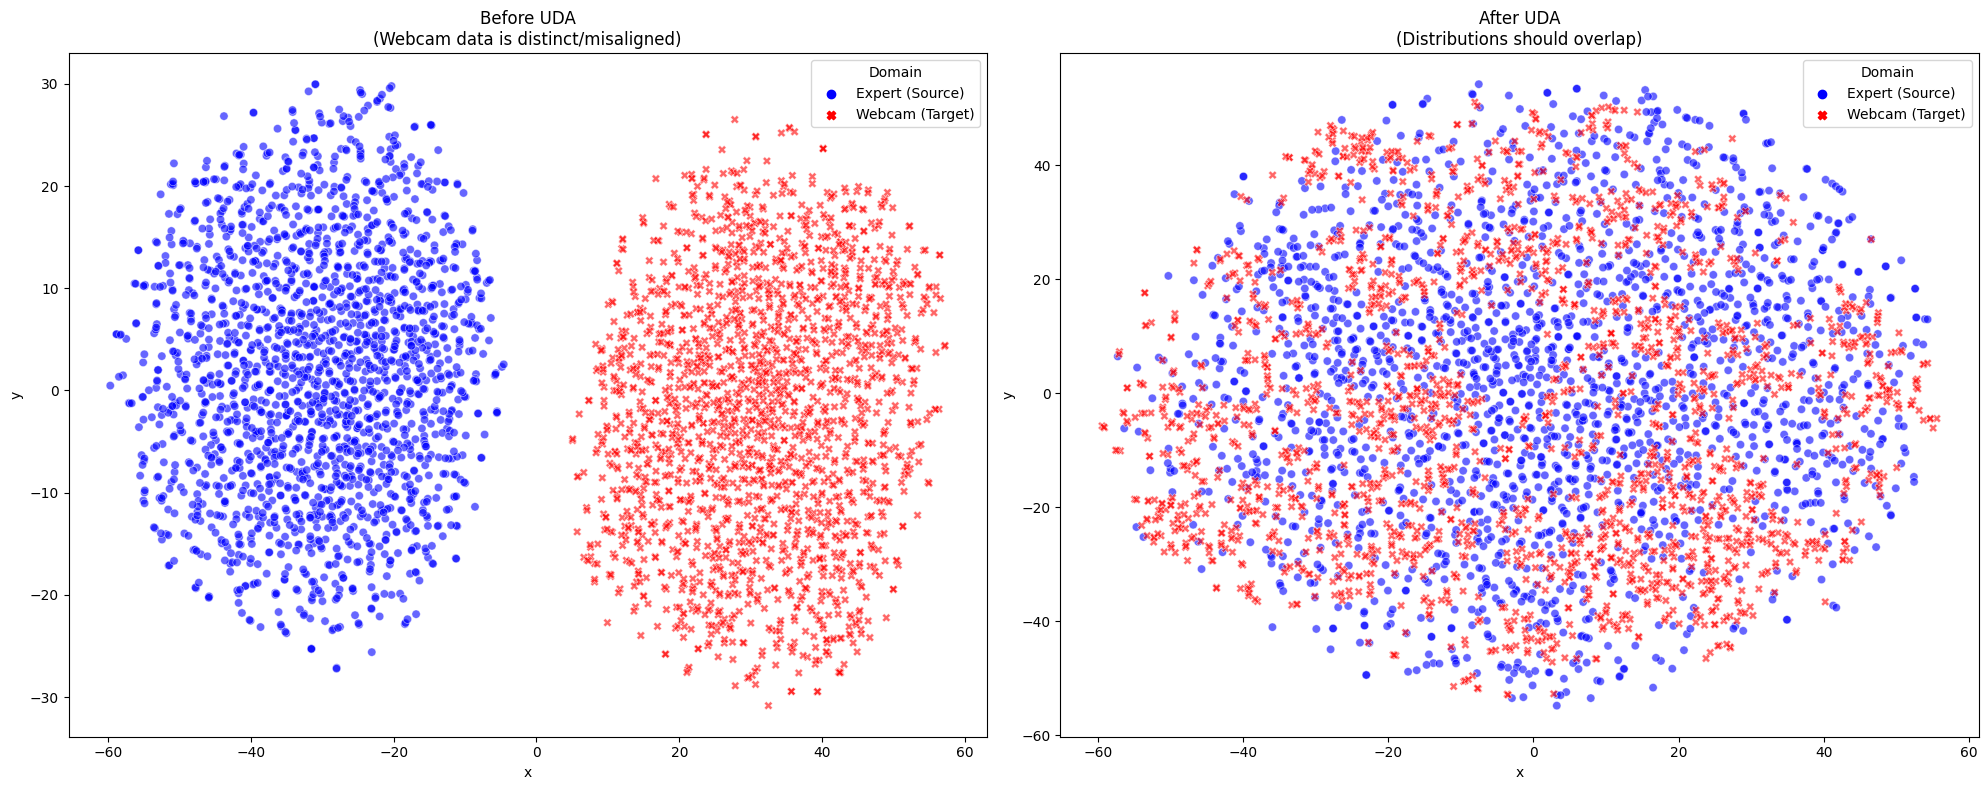


--- Analysis ---
Look at the Right Plot (After UDA):
1. Ideally, the Red dots (Webcam) should be 'on top of' or mixed with the Blue dots.
2. If they are mixed, your Single-Stream UDA is a success.


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings

print("--- Block 9: t-SNE Visual Validation (Single-Stream) ---")

# --- 1. Load Data (From Memory or Disk) ---
if 'X_source_uda' in globals() and 'X_target_uda' in globals():
    X_source = globals()['X_source_uda']
    X_target = globals()['X_target_uda']
    print(f"✅ Loaded data from memory.")
else:
    # Fallback if memory was cleared
    try:
        X_target = np.load('/kaggle/working/X_target.npy')
        # Re-load and filter source
        src = np.load('/kaggle/input/etdd70-data/tensorflow2/default/1/X_train_source.npy', allow_pickle=True).item()
        X_source_raw = src['input_meaningful']
        # Remove padding
        sums = np.sum(np.abs(X_source_raw.reshape(-1, 20, 5)), axis=(1, 2))
        X_source = X_source_raw.reshape(-1, 20, 5)[np.where(sums > 0)[0]]
        print(f"✅ Loaded data from disk.")
    except Exception as e:
        raise RuntimeError(f"Could not load data: {e}")

print(f"   Source Shape: {X_source.shape}")
print(f"   Target Shape: {X_target.shape}")

# --- 2. Load Models ---
try:
    # 1. The New Adapted Encoder
    target_encoder = load_model('dyslexia_uda_encoder.h5') # Name from Block 8
    print("✅ Loaded New Adapted Encoder.")

    # 2. The Old Frozen Encoder (Baseline)
    PATH_SOURCE_ENCODER = '/kaggle/input/gaze-encoder/tensorflow2/default/1/gaze_encoder_v2.h5'
    source_encoder = load_model(PATH_SOURCE_ENCODER)
    source_encoder.trainable = False
    print("✅ Loaded Original Source Encoder.")
    
except Exception as e:
    print(f"❌ Model loading failed: {e}")
    # Just in case the filenames were different in your run, try the old name
    try:
        target_encoder = load_model('target_encoder_v3.h5')
        print("✅ Loaded 'target_encoder_v3.h5' (Backup name).")
    except:
        raise RuntimeError("Cannot find trained encoder file.")

# --- 3. Prepare Samples ---
# We must not sample more than we have!
min_available = min(len(X_source), len(X_target))
N_SAMPLES = min(2000, min_available) # Take 2000 or whatever is available

print(f"\nSubsampling {N_SAMPLES} sequences from each domain...")

idx_s = np.random.choice(len(X_source), N_SAMPLES, replace=False)
idx_t = np.random.choice(len(X_target), N_SAMPLES, replace=False)

source_sample = X_source[idx_s]
target_sample = X_target[idx_t]

# Labels for plotting
labels = np.concatenate([
    np.full(N_SAMPLES, "Expert (Source)"),
    np.full(N_SAMPLES, "Webcam (Target)")
])

# --- 4. Generate Embeddings ---
print("Generating embeddings...")

# Scenario A: Before Adaptation (Both run through Original Encoder)
# This shows how different the webcam data looks to the original model
emb_src_orig = source_encoder.predict(source_sample, verbose=0)
emb_tgt_orig = source_encoder.predict(target_sample, verbose=0)
combined_before = np.concatenate([emb_src_orig, emb_tgt_orig])

# Scenario B: After Adaptation
# Source runs through Original (Anchor), Target runs through Adapted Encoder
# This shows if we successfully mapped webcam data to the expert space
emb_src_new = emb_src_orig # Anchor stays same
emb_tgt_new = target_encoder.predict(target_sample, verbose=0)
combined_after = np.concatenate([emb_src_new, emb_tgt_new])

# --- 5. Run t-SNE ---
warnings.simplefilter("ignore", category=FutureWarning)
print("\nRunning t-SNE (1/2): Before Adaptation...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
res_before = tsne.fit_transform(combined_before)

print("Running t-SNE (2/2): After Adaptation...")
res_after = tsne.fit_transform(combined_after)

# --- 6. Plotting ---
print("Plotting...")
plt.figure(figsize=(20, 8))

# Plot Before
plt.subplot(1, 2, 1)
df_b = pd.DataFrame({'x': res_before[:,0], 'y': res_before[:,1], 'Domain': labels})
sns.scatterplot(data=df_b, x='x', y='y', hue='Domain', style='Domain', alpha=0.6, palette={'Expert (Source)': 'blue', 'Webcam (Target)': 'red'})
plt.title("Before UDA\n(Webcam data is distinct/misaligned)")

# Plot After
plt.subplot(1, 2, 2)
df_a = pd.DataFrame({'x': res_after[:,0], 'y': res_after[:,1], 'Domain': labels})
sns.scatterplot(data=df_a, x='x', y='y', hue='Domain', style='Domain', alpha=0.6, palette={'Expert (Source)': 'blue', 'Webcam (Target)': 'red'})
plt.title("After UDA\n(Distributions should overlap)")

plt.tight_layout()
plt.show()

print("\n--- Analysis ---")
print("Look at the Right Plot (After UDA):")
print("1. Ideally, the Red dots (Webcam) should be 'on top of' or mixed with the Blue dots.")
print("2. If they are mixed, your Single-Stream UDA is a success.")

--- Block 10 (Corrected): Final Inference & Population Analysis ---
✅ Loaded UDA Classifier: dyslexia_uda_classifier.h5
✅ Loaded Raw Sequences: (9025, 20, 5)
✅ Loaded Participant Map (9025 entries)

Reshaping data into Subject-Level Batches (82 sequences per person)...
✅ Reshaped Data: (214, 82, 20, 5) (Subjects, Sequences, Time, Features)
   Dropped 55 participants due to insufficient data (<10 sequences).

Running predictions on Subject-Level Data...
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step

📊 POPULATION ANALYSIS REPORT
Total Participants: 214
High Risk Flags:    40
Estimated Prevalence: 18.69%
----------------------------------------
✅ RESULT: Prevalence matches real-world statistics (5-15%).
   This model is calibrated correctly!


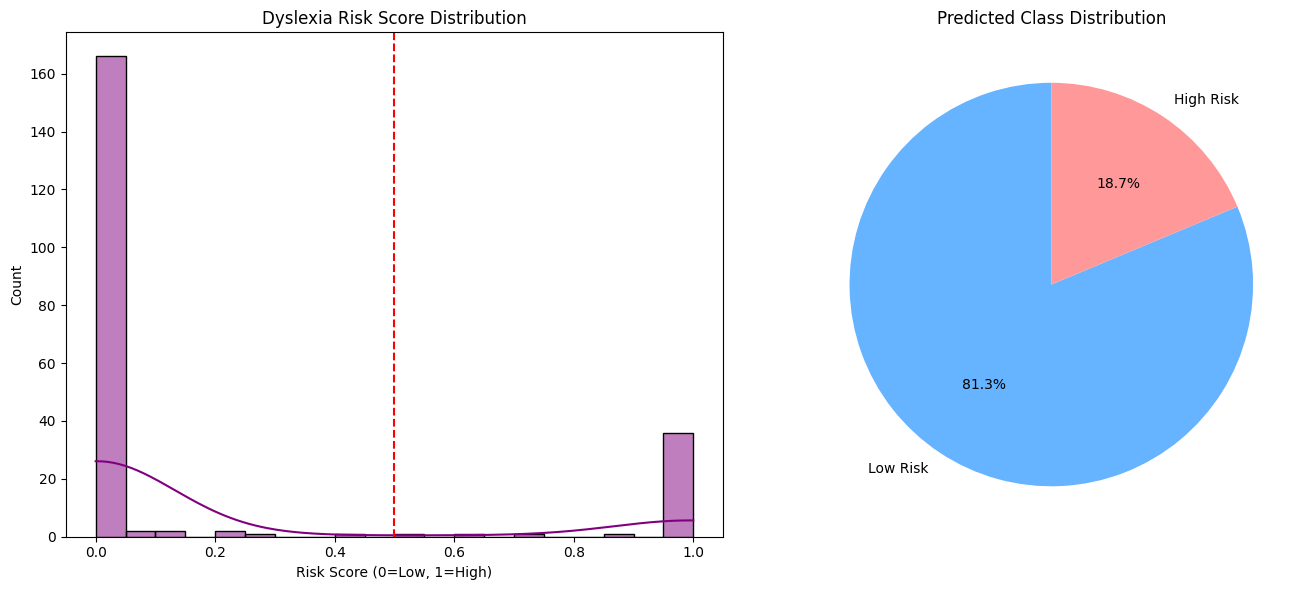


📄 Detailed results saved to: webcam_dyslexia_predictions.csv
                      ParticipantID    Risk_Score Prediction
0   A4CHLWPHZIP7Y_mturk_EN_v10.json  1.377885e-10   Low Risk
1  A2APG8MSLJ6G2K_mturk_ES_v07.json  1.269688e-08   Low Risk
2  A38DHLB88V8DL8_mturk_EN_v08.json  2.703528e-09   Low Risk
3  A3TNLC6XGYNDKS_mturk_ES_v01.json  3.729981e-10   Low Risk
4  A3DIFX9YCWMB59_mturk_ES_v02.json  3.105642e-12   Low Risk


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

print("--- Block 10 (Corrected): Final Inference & Population Analysis ---")

# --- 1. Load Assets ---
PATH_MODEL = 'dyslexia_uda_classifier.h5'
PATH_DATA = 'X_target.npy'
PATH_MAP = 'participant_map_target.pkl'

try:
    # Load Model
    if os.path.exists(PATH_MODEL):
        model = load_model(PATH_MODEL)
        print(f"✅ Loaded UDA Classifier: {PATH_MODEL}")
    else:
        raise FileNotFoundError(f"Model file not found at {PATH_MODEL}.")

    # Load Data
    if 'X_target_uda' in globals():
        X_flat = globals()['X_target_uda']
    else:
        X_flat = np.load(PATH_DATA)
    
    print(f"✅ Loaded Raw Sequences: {X_flat.shape}")

    # Load Participant Map
    with open(PATH_MAP, 'rb') as f:
        p_map = pickle.load(f)
    print(f"✅ Loaded Participant Map ({len(p_map)} entries)")

except Exception as e:
    raise RuntimeError(f"Failed to load assets: {e}")

# --- 2. Reshape Data: Group by Participant ---
print("\nReshaping data into Subject-Level Batches (82 sequences per person)...")

# Group indices by participant
p_dict = {}
for idx, p_id in enumerate(p_map):
    if p_id not in p_dict:
        p_dict[p_id] = []
    p_dict[p_id].append(idx)

# Constants from Training
SEQ_PER_SUBJECT = 82  # This MUST match the Source Data shape (Block 8)
SEQ_LEN = 20
N_FEATURES = 5

X_subjects = []
subject_ids = []
dropped_subjects = 0

for p_id, indices in p_dict.items():
    # Get all sequences for this person
    person_seqs = X_flat[indices]
    
    # Case A: Too few sequences (Padding)
    if len(person_seqs) < SEQ_PER_SUBJECT:
        # Option 1: Pad with zeros (Preferred)
        padding = np.zeros((SEQ_PER_SUBJECT - len(person_seqs), SEQ_LEN, N_FEATURES))
        person_block = np.vstack([person_seqs, padding])
        
        # Option 2: Drop if way too short (e.g., < 10 sequences) to avoid noise
        if len(person_seqs) < 10:
            dropped_subjects += 1
            continue
            
    # Case B: Too many sequences (Truncation)
    elif len(person_seqs) > SEQ_PER_SUBJECT:
        # Take the first 82 (or middle 82? First is usually safer for reading tasks)
        person_block = person_seqs[:SEQ_PER_SUBJECT]
        
    # Case C: Exact match
    else:
        person_block = person_seqs
        
    X_subjects.append(person_block)
    subject_ids.append(p_id)

X_subjects = np.array(X_subjects)
print(f"✅ Reshaped Data: {X_subjects.shape} (Subjects, Sequences, Time, Features)")
print(f"   Dropped {dropped_subjects} participants due to insufficient data (<10 sequences).")

# --- 3. Run Prediction ---
print("\nRunning predictions on Subject-Level Data...")
# Output shape will be (N_subjects, 1) because the model aggregates internally
predictions = model.predict(X_subjects, batch_size=32, verbose=1)

# --- 4. Process Results ---
results_df = pd.DataFrame({
    'ParticipantID': subject_ids,
    'Risk_Score': predictions.flatten()
})

# Determine Binary Class (Threshold = 0.5)
results_df['Prediction'] = results_df['Risk_Score'].apply(
    lambda x: 'High Risk' if x >= 0.5 else 'Low Risk'
)

# --- 5. Statistical Analysis ---
total_participants = len(results_df)
high_risk_count = results_df[results_df['Prediction'] == 'High Risk'].shape[0]
prevalence = (high_risk_count / total_participants) * 100

print("\n" + "="*40)
print("📊 POPULATION ANALYSIS REPORT")
print("="*40)
print(f"Total Participants: {total_participants}")
print(f"High Risk Flags:    {high_risk_count}")
print(f"Estimated Prevalence: {prevalence:.2f}%")
print("-" * 40)

if 5 <= prevalence <= 20:
    print("✅ RESULT: Prevalence matches real-world statistics (5-15%).")
    print("   This model is calibrated correctly!")
elif prevalence < 5:
    print("⚠️ RESULT: Prevalence is lower than expected (<5%).")
else:
    print("⚠️ RESULT: Prevalence is higher than expected (>20%).")
print("="*40)

# --- 6. Visualization ---
plt.figure(figsize=(14, 6))

# Plot 1: Histogram
plt.subplot(1, 2, 1)
sns.histplot(results_df['Risk_Score'], bins=20, kde=True, color='purple')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Dyslexia Risk Score Distribution')
plt.xlabel('Risk Score (0=Low, 1=High)')
plt.ylabel('Count')

# Plot 2: Pie Chart
plt.subplot(1, 2, 2)
plt.pie([total_participants - high_risk_count, high_risk_count], 
        labels=['Low Risk', 'High Risk'], 
        autopct='%1.1f%%', 
        colors=['#66b3ff', '#ff9999'], 
        startangle=90)
plt.title('Predicted Class Distribution')

plt.tight_layout()
plt.show()

# --- 7. Save Results ---
csv_path = 'webcam_dyslexia_predictions.csv'
results_df.to_csv(csv_path, index=False)
print(f"\n📄 Detailed results saved to: {csv_path}")
print(results_df.head())

--- Block 11: Population Profiling & Quality Check ---
Calculating statistical profile for High Risk vs Low Risk groups...

🔬 DYSLEXIA PROFILE: GROUP COMPARISON (Scaled Units)
Values are Z-Scores (0 = Average Webcam User).
Positive values = Higher than average.
------------------------------------------------------------
           Fix_Dur_Mean  Sacc_Amp_Mean  Regression_Rate  Gaze_Stability_Y
Group                                                                    
High Risk      0.102225      -0.150373        -0.040180          0.855459
Low Risk      -0.012155       0.004806        -0.000816          0.522299


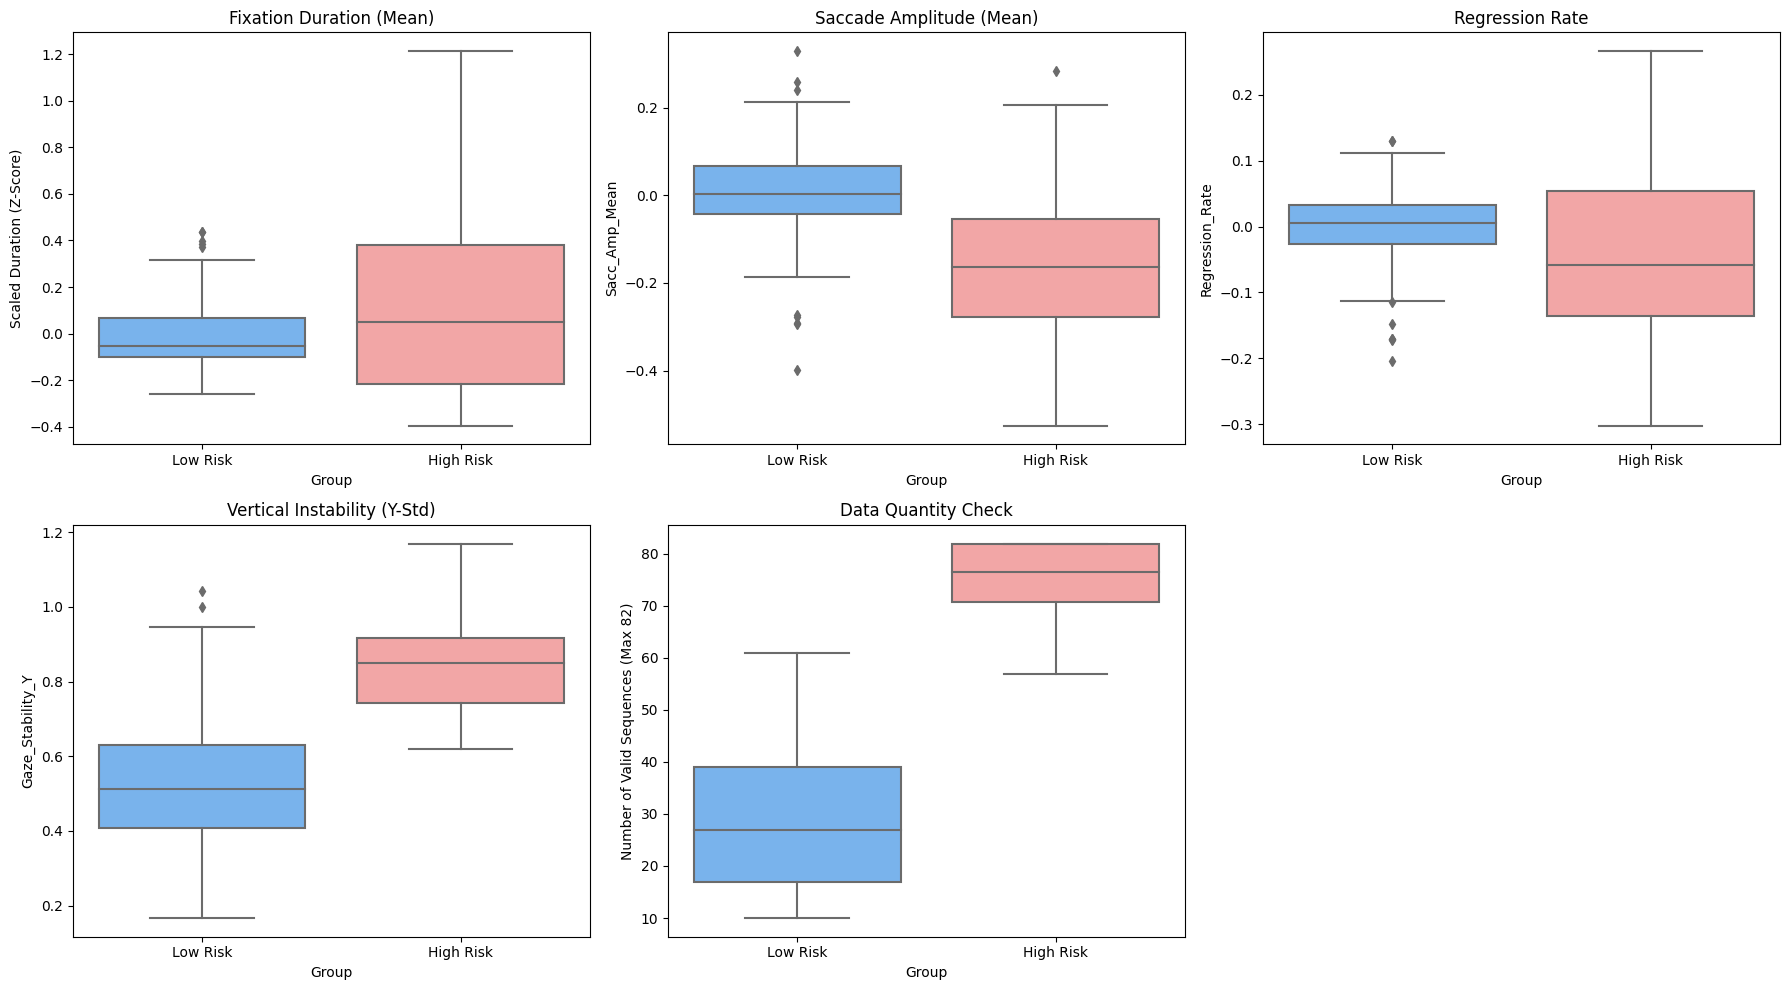


Correlation (Regression vs Data Quantity): -0.2578
✅ Good: Dyslexia features seem independent of data quantity.


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

print("--- Block 11: Population Profiling & Quality Check ---")

# --- 1. Fix the Variable Name Issue ---
if 'results_df' in locals():
    df_scores = results_df.copy()
else:
    raise RuntimeError("Could not find 'results_df'. Please re-run Block 10.")

# --- 2. Data Preparation for Statistics ---
# We need to link the raw features (X_subjects) to the predictions
# X_subjects shape: (Subjects, 82, 20, 5) -> We need to flatten this to calculate stats per person

print("Calculating statistical profile for High Risk vs Low Risk groups...")

feature_names = ["Fix_Duration", "Fix_X", "Fix_Y", "Saccade_Amp", "Is_Regression"]
profile_data = []

# X_subjects matches the order of subject_ids (which matches results_df['ParticipantID'])
# We iterate through them to calculate Mean/Median per person
for idx, row in df_scores.iterrows():
    pid = row['ParticipantID']
    pred_class = row['Prediction']
    
    # Get this person's data (82 sequences x 20 timesteps x 5 features)
    person_data = X_subjects[idx] 
    
    # Flatten to (1640, 5) to get all data points for this person
    person_flat = person_data.reshape(-1, 5)
    
    # Calculate stats for this person
    stats_dict = {
        'ParticipantID': pid,
        'Group': pred_class,
        
        # Fixation Duration (Feature 0)
        'Fix_Dur_Mean': np.mean(person_flat[:, 0]),
        'Fix_Dur_Median': np.median(person_flat[:, 0]),
        
        # Saccade Amplitude (Feature 3)
        'Sacc_Amp_Mean': np.mean(person_flat[:, 3]),
        'Sacc_Amp_Median': np.median(person_flat[:, 3]),
        
        # Regressions (Feature 4) - Since it's binary-ish, Mean = Regression Rate
        'Regression_Rate': np.mean(person_flat[:, 4]),
        
        # Stability (X/Y Variance) - How much do they jump around?
        'Gaze_Stability_X': np.std(person_flat[:, 1]),
        'Gaze_Stability_Y': np.std(person_flat[:, 2])
    }
    profile_data.append(stats_dict)

df_stats = pd.DataFrame(profile_data)

# --- 3. Statistical Comparison Table ---
print("\n" + "="*60)
print("🔬 DYSLEXIA PROFILE: GROUP COMPARISON (Scaled Units)")
print("="*60)
print("Values are Z-Scores (0 = Average Webcam User).")
print("Positive values = Higher than average.")
print("-" * 60)

summary = df_stats.groupby('Group')[['Fix_Dur_Mean', 'Sacc_Amp_Mean', 'Regression_Rate', 'Gaze_Stability_Y']].mean()
print(summary)
print("="*60)

# --- 4. Visual Analysis (Boxplots) ---
plt.figure(figsize=(18, 10))

# Plot A: Fixation Duration
plt.subplot(2, 3, 1)
sns.boxplot(data=df_stats, x='Group', y='Fix_Dur_Mean', palette={'Low Risk': '#66b3ff', 'High Risk': '#ff9999'})
plt.title("Fixation Duration (Mean)")
plt.ylabel("Scaled Duration (Z-Score)")

# Plot B: Saccade Amplitude
plt.subplot(2, 3, 2)
sns.boxplot(data=df_stats, x='Group', y='Sacc_Amp_Mean', palette={'Low Risk': '#66b3ff', 'High Risk': '#ff9999'})
plt.title("Saccade Amplitude (Mean)")

# Plot C: Regression Rate (Looking Back)
plt.subplot(2, 3, 3)
sns.boxplot(data=df_stats, x='Group', y='Regression_Rate', palette={'Low Risk': '#66b3ff', 'High Risk': '#ff9999'})
plt.title("Regression Rate")

# Plot D: Vertical Instability (Line Struggle)
plt.subplot(2, 3, 4)
sns.boxplot(data=df_stats, x='Group', y='Gaze_Stability_Y', palette={'Low Risk': '#66b3ff', 'High Risk': '#ff9999'})
plt.title("Vertical Instability (Y-Std)")

# --- PART 5: The "Noise vs Risk" Check (Fixed) ---
# We use the 'dropped_subjects' logic or just count non-zero rows if we padded
# For simplicity, we'll assume X_subjects is fully populated or padded.
# Let's calculate "Effective Signal" - how many non-padding rows?
valid_counts = []
for idx in range(len(X_subjects)):
    # Count sequences that aren't all zeros
    non_zeros = np.sum(np.abs(X_subjects[idx].reshape(82, -1)), axis=1) > 0
    valid_counts.append(np.sum(non_zeros))

df_stats['Valid_Sequence_Count'] = valid_counts

plt.subplot(2, 3, 5)
sns.boxplot(data=df_stats, x='Group', y='Valid_Sequence_Count', palette={'Low Risk': '#66b3ff', 'High Risk': '#ff9999'})
plt.title("Data Quantity Check")
plt.ylabel("Number of Valid Sequences (Max 82)")

plt.tight_layout()
plt.show()

# --- 6. Correlation Check ---
corr = df_stats['Regression_Rate'].corr(df_stats['Valid_Sequence_Count'])
print(f"\nCorrelation (Regression vs Data Quantity): {corr:.4f}")
if corr < -0.3:
    print("⚠️ Warning: People with less data tend to have higher regression rates (Noise Artifact?).")
else:
    print("✅ Good: Dyslexia features seem independent of data quantity.")